In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# — Load raw data into original_df so 'Low' is accessible —
original_df = pd.read_csv("gold_with_indicators.csv", parse_dates=["Local time"])


In [2]:
import pandas as pd

df_check = pd.read_csv("gold_with_indicators.csv")
print(df_check.columns.tolist())


['Local time', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA_9', 'EMA_21', 'EMA_50', 'EMA_200', 'MACD', 'MACD_hist', 'RSI_14', 'ATR_14', 'STDDEV_20', 'ADX_14']


In [3]:
!pip install ta


Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd
from pathlib import Path

# Set your data directory (you already uploaded to "GOLD" folder)
data_dir = Path("GOLD")

# Lists of filenames
ask_files = [f"GOLD_ASK{year}.csv" for year in range(2020, 2026)]
bid_files = [f"GOLD_BID{year}.csv" for year in range(2020, 2026)]

# 🔁 Updated read function with comma separator
def read_gold_csv(file_path):
    df = pd.read_csv(file_path)  # auto-detect comma separator
    print(f"\n✅ Preview from file: {file_path.name}")
    print(df.head())  # show a fe


In [5]:
import pandas as pd
import os

# ─── CONFIG ───────────────────────────────────────────────────────────────────
# Relative path to the folder containing your 12 CSVs:
# (Assumes this notebook lives in a subfolder of your repo; adjust "../GOLD" if needed)
data_folder = os.path.join("..", "GOLD")
# ────────────────────────────────────────────────────────────────────────────────

# Prepare a list to collect each year's cleaned data
all_years_data = []

# Loop through each year 2020–2025
for year in range(2020, 2026):
    ask_file = os.path.join(data_folder, f"GOLD_ASK{year}.csv")
    bid_file = os.path.join(data_folder, f"GOLD_BID{year}.csv")

    # Read ASK and BID (comma-separated)
    df_ask = pd.read_csv(ask_file)
    df_bid = pd.read_csv(bid_file)

    # Rename columns so we can merge
    df_ask.columns = ["Gmt time", "Open_ask", "High_ask", "Low_ask", "Close_ask", "Volume_ask"]
    df_bid.columns = ["Gmt time", "Open_bid", "High_bid", "Low_bid", "Close_bid", "Volume_bid"]

    # Merge on the GMT timestamp
    df = pd.merge(df_ask, df_bid, on="Gmt time", how="inner")

    # Parse 'Gmt time' into datetime
    df["Gmt time"] = pd.to_datetime(df["Gmt time"], format="%d.%m.%Y %H:%M:%S.%f")

    # Compute midpoint OHLC and average volume
    df["Open"]   = (df["Open_ask"]  + df["Open_bid"])  / 2
    df["High"]   = (df["High_ask"]  + df["High_bid"])  / 2
    df["Low"]    = (df["Low_ask"]   + df["Low_bid"])   / 2
    df["Close"]  = (df["Close_ask"] + df["Close_bid"]) / 2
    df["Volume"] = (df["Volume_ask"] + df["Volume_bid"]) / 2

    # Convert to WIB local time (UTC+7)
    df["Local time"] = df["Gmt time"] + pd.Timedelta(hours=7)

    # Select final columns
    df_clean = df[["Local time", "Open", "High", "Low", "Close", "Volume"]]

    # Append to list
    all_years_data.append(df_clean)

# Concatenate all years
gold_midpoint = pd.concat(all_years_data, ignore_index=True)

# Sort by time and reset index
gold_midpoint = gold_midpoint.sort_values("Local time").reset_index(drop=True)

# Preview the merged midpoint data
print("✅ Parsed and merged midpoint data – preview:")
display(gold_midpoint.head())

# (Optional) Save to CSV for later steps
gold_midpoint.to_csv("gold_midpoint_5min_wib.csv", index=False)
print("✅ Saved merged midpoint file as 'gold_midpoint_5min_wib.csv'")


✅ Parsed and merged midpoint data – preview:


,Local time,Open,High,Low,Close,Volume
0,2020-01-01 07:00:00,1517.465,1517.465,1517.465,1517.465,0.0
1,2020-01-01 07:05:00,1517.465,1517.465,1517.465,1517.465,0.0
2,2020-01-01 07:10:00,1517.465,1517.465,1517.465,1517.465,0.0
3,2020-01-01 07:15:00,1517.465,1517.465,1517.465,1517.465,0.0
4,2020-01-01 07:20:00,1517.465,1517.465,1517.465,1517.465,0.0


✅ Saved merged midpoint file as 'gold_midpoint_5min_wib.csv'


In [6]:
import ta  # Technical Analysis library
import pandas as pd

# Use the already-created DataFrame: `gold_midpoint`
df = gold_midpoint.copy()

# 1. EMAs
for span in [9, 21, 50, 200]:
    df[f'EMA_{span}'] = df['Close'].ewm(span=span, adjust=False).mean()

# 2. RSI(14)
df['RSI_14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

# 3. MACD (12,26) + Histogram
macd = ta.trend.MACD(df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD']      = macd.macd()
df['MACD_hist'] = macd.macd_diff()

# 4. ATR(14)
df['ATR_14'] = ta.volatility.AverageTrueRange(
    high=df['High'], low=df['Low'], close=df['Close'], window=14
).average_true_range()

# 5. Rolling StdDev (20)
df['STDDEV_20'] = df['Close'].rolling(window=20).std()

# 6. ADX (14), +DI, –DI
adx = ta.trend.ADXIndicator(
    high=df['High'], low=df['Low'], close=df['Close'], window=14
)
df['ADX_14'] = adx.adx()
df['+DI_14'] = adx.adx_pos()
df['-DI_14'] = adx.adx_neg()

# Preview
print("✅ Core indicators added. Preview:")
display(df.filter(regex='EMA|RSI|MACD|ATR|STDDEV|ADX').head())


✅ Core indicators added. Preview:


,EMA_9,EMA_21,EMA_50,EMA_200,RSI_14,MACD,MACD_hist,ATR_14,STDDEV_20,ADX_14
0,1517.465,1517.465,1517.465,1517.465,NaN,NaN,NaN,0.0,NaN,0.0
1,1517.465,1517.465,1517.465,1517.465,NaN,NaN,NaN,0.0,NaN,0.0
2,1517.465,1517.465,1517.465,1517.465,NaN,NaN,NaN,0.0,NaN,0.0
3,1517.465,1517.465,1517.465,1517.465,NaN,NaN,NaN,0.0,NaN,0.0
4,1517.465,1517.465,1517.465,1517.465,NaN,NaN,NaN,0.0,NaN,0.0


##  Feature Engineering: Core Technical Indicators

In this section, we enrich the raw gold 5-minute midpoint price data with a curated set of technical indicators commonly used in momentum, trend-following, and volatility-based strategies. These indicators are later used as features for modeling and dimensionality reduction.

###  Indicators Included

- **EMA (9, 21, 50, 200)**: Exponential moving averages that capture trend behavior at different time scales.
- **RSI (14)**: A momentum oscillator comparing recent gains to losses. Values above 70 indicate overbought; below 30 indicate oversold.
- **MACD (12, 26, 9)**: Measures momentum and trend strength via the difference between short and long EMAs.
- **MACD Histogram**: Visualizes the rate of MACD convergence/divergence.
- **ATR (14)**: Average True Range estimates recent volatility, useful for risk and stop-loss calculations.
- **Rolling StdDev (20)**: A statistical measure of price dispersion over 20 bars.
- **ADX (+DI, –DI)**: The Average Directional Index gauges trend strength and directionality.

These indicators are researched based on popular 

These features are computed using the `ta` (technical analysis) Python library and stored in the `df` DataFrame for later use.

###  Mathematical Concepts Used

This cell leverages:
- **Exponential smoothing** (for EMAs and MACD),
- **Vector algebra** (price deltas in RSI),
- **Rolling window statistics** (StdDev, ATR),
- **Directional volatility logic** (ADX family indicators).

All indicators are calculated in a vectorized fashion and serve as model-ready inputs for both supervised ML and unsupervised techniques like PCA.



In [8]:
import pandas as pd
from ta.trend import EMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import AverageTrueRange
from sklearn.preprocessing import StandardScaler

# Load clean midpoint file
df = pd.read_csv("gold_midpoint_5min_wib.csv", parse_dates=["Local time"])

# Set up the indicators
df["EMA_9"] = EMAIndicator(close=df["Close"], window=9).ema_indicator()
df["EMA_21"] = EMAIndicator(close=df["Close"], window=21).ema_indicator()
df["EMA_50"] = EMAIndicator(close=df["Close"], window=50).ema_indicator()
df["EMA_200"] = EMAIndicator(close=df["Close"], window=200).ema_indicator()

macd = MACD(close=df["Close"])
df["MACD"] = macd.macd()
df["MACD_hist"] = macd.macd_diff()

df["RSI_14"] = RSIIndicator(close=df["Close"], window=14).rsi()

atr = AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"], window=14)
df["ATR_14"] = atr.average_true_range()

df["STDDEV_20"] = df["Close"].rolling(window=20).std()

adx = ADXIndicator(high=df["High"], low=df["Low"], close=df["Close"], window=14)
df["ADX_14"] = adx.adx()

# Drop early NaNs
df.dropna(inplace=True)

# ✅ Save this as the master dataset with indicators
df.to_csv("gold_with_indicators.csv", index=False)

print("✅ Indicators added and saved to 'gold_with_indicators.csv'")
print(df.head())


✅ Indicators added and saved to 'gold_with_indicators.csv'
             Local time      Open      High       Low     Close  Volume  \
199 2020-01-01 23:35:00  1517.465  1517.465  1517.465  1517.465     0.0   
200 2020-01-01 23:40:00  1517.465  1517.465  1517.465  1517.465     0.0   
201 2020-01-01 23:45:00  1517.465  1517.465  1517.465  1517.465     0.0   
202 2020-01-01 23:50:00  1517.465  1517.465  1517.465  1517.465     0.0   
203 2020-01-01 23:55:00  1517.465  1517.465  1517.465  1517.465     0.0   

        EMA_9    EMA_21    EMA_50   EMA_200  MACD  MACD_hist  RSI_14  ATR_14  \
199  1517.465  1517.465  1517.465  1517.465   0.0        0.0   100.0     0.0   
200  1517.465  1517.465  1517.465  1517.465   0.0        0.0   100.0     0.0   
201  1517.465  1517.465  1517.465  1517.465   0.0        0.0   100.0     0.0   
202  1517.465  1517.465  1517.465  1517.465   0.0        0.0   100.0     0.0   
203  1517.465  1517.465  1517.465  1517.465   0.0        0.0   100.0     0.0   

     STDD

In [9]:
import pandas as pd

# Load the enriched data
df = pd.read_csv("gold_with_indicators.csv", parse_dates=["Local time"])

# 👁️ Quick stats for sanity check
print(df.describe())

# 🔍 Check NaNs and unique values per indicator
indicator_cols = [col for col in df.columns if col.startswith("EMA") or
                  col.startswith("MACD") or col.startswith("RSI") or
                  col.startswith("ATR") or col.startswith("STDDEV") or
                  col.startswith("ADX")]

for col in indicator_cols:
    print(f"\n🔎 {col}:")
    print(f"NaNs: {df[col].isna().sum()}, Unique values: {df[col].nunique()}")


                          Local time           Open           High  \
count                         360550  360550.000000  360550.000000   
mean   2022-08-22 22:09:52.802662400    2000.025115    2000.738905   
min              2020-01-01 23:35:00    1453.938500    1456.753500   
25%              2021-04-19 15:01:15    1785.760375    1786.304250   
50%              2022-08-19 11:42:30    1889.444250    1890.195000   
75%              2023-12-21 13:58:45    2027.616125    2028.193375   
max              2025-05-02 06:55:00    3497.455000    3500.215000   
std                              NaN     355.994497     356.132721   

                 Low          Close        Volume          EMA_9  \
count  360550.000000  360550.000000  3.605500e+05  360550.000000   
mean     1999.300556    2000.029423  1.541201e+05    2000.010341   
min      1451.320000    1453.953500  0.000000e+00    1459.281396   
25%      1785.155375    1785.761625  5.105000e+04    1785.746566   
50%      1888.745750    1889.

In [10]:
from sklearn.preprocessing import StandardScaler

# Exclude time and price columns, only keep indicators
features = df[indicator_cols]

# Standardize
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert back to DataFrame for easy use
df_scaled = pd.DataFrame(features_scaled, columns=[f"{col}_z" for col in indicator_cols])
df_scaled["Local time"] = df["Local time"]

# ✅ Save it
df_scaled.to_csv("gold_indicators_standardized.csv", index=False)

print("✅ Standardized indicator data saved to 'gold_indicators_standardized.csv'")


✅ Standardized indicator data saved to 'gold_indicators_standardized.csv'


In [11]:
import pandas as pd

# Load the enriched gold data with indicators
df = pd.read_csv("gold_with_indicators.csv", parse_dates=["Local time"])

# Identify constant columns
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]

print("🧾 Constant columns detected and removed:", constant_cols)

# Drop constant columns
df_sane = df.drop(columns=constant_cols)

# Save cleaned dataset for standardization step
df_sane.to_csv("gold_indicators_sanitized.csv", index=False)
print("✅ Saved sanitized dataset to 'gold_indicators_sanitized.csv'")


🧾 Constant columns detected and removed: []
✅ Saved sanitized dataset to 'gold_indicators_sanitized.csv'


In [12]:
from sklearn.preprocessing import StandardScaler

# Reload sanitized data
df = pd.read_csv("gold_indicators_sanitized.csv", parse_dates=["Local time"])

# Identify numeric columns (excluding time)
features = df.drop(columns=["Local time"]).select_dtypes(include="number").columns.tolist()

# Apply StandardScaler
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

# Save result
df_scaled.to_csv("gold_indicators_standardized.csv", index=False)

print("✅ Standardization complete. Preview:")
display(df_scaled.head())


✅ Standardization complete. Preview:


,Local time,Open,High,Low,Close,Volume,EMA_9,EMA_21,EMA_50,EMA_200,MACD,MACD_hist,RSI_14,ATR_14,STDDEV_20,ADX_14
0,2020-01-01 23:35:00,-1.355529,-1.357007,-1.354021,-1.355516,-1.004493,-1.355557,-1.355615,-1.355752,-1.35651,-0.024411,-0.000084,4.243234,-1.567265,-1.062336,-2.378793
1,2020-01-01 23:40:00,-1.355529,-1.357007,-1.354021,-1.355516,-1.004493,-1.355557,-1.355615,-1.355752,-1.35651,-0.024411,-0.000084,4.243234,-1.567265,-1.062336,-2.378793
2,2020-01-01 23:45:00,-1.355529,-1.357007,-1.354021,-1.355516,-1.004493,-1.355557,-1.355615,-1.355752,-1.35651,-0.024411,-0.000084,4.243234,-1.567265,-1.062336,-2.378793
3,2020-01-01 23:50:00,-1.355529,-1.357007,-1.354021,-1.355516,-1.004493,-1.355557,-1.355615,-1.355752,-1.35651,-0.024411,-0.000084,4.243234,-1.567265,-1.062336,-2.378793
4,2020-01-01 23:55:00,-1.355529,-1.357007,-1.354021,-1.355516,-1.004493,-1.355557,-1.355615,-1.355752,-1.35651,-0.024411,-0.000084,4.243234,-1.567265,-1.062336,-2.378793


In [13]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

# Load standardized dataset
df = pd.read_csv("gold_indicators_sanitized.csv")

# Keep a copy of the timestamp for later
timestamps = df["Local time"]

# Drop non-numeric columns for PCA
X = df.drop(columns=["Local time"])

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Print explained variance
explained_variance = pca.explained_variance_ratio_

print("✅ Explained Variance per Principal Component:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f}")


✅ Explained Variance per Principal Component:
PC1: 1.0000
PC2: 0.0000
PC3: 0.0000
PC4: 0.0000
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000
PC10: 0.0000
PC11: 0.0000
PC12: 0.0000
PC13: 0.0000
PC14: 0.0000
PC15: 0.0000


##  Feature Pipeline: Indicator Enrichment to PCA Compression

This section builds a full preprocessing pipeline that transforms raw 5-minute gold midpoint data into a standardized, 
compact feature space suitable for machine learning and regime modeling. 
The pipeline starts with technical indicator extraction and ends with Principal Component Analysis (PCA) for dimensionality reduction.

### Steps Performed

- **Indicator Engineering**: We compute common trend, momentum, and volatility indicators using the `ta` library, including:
  - **EMA (9, 21, 50, 200)** for multi-timescale trends
  - **RSI (14)** and **MACD + Histogram** for momentum strength
  - **ATR (14)** and **Rolling StdDev (20)** for volatility
  - **ADX (14)** to quantify directional strength

- **Sanity Check**: We perform exploratory checks for missing values and low-variance (constant) features to clean the dataset.

- **Standardization**: All indicator columns are z-score standardized using `StandardScaler` to ensure comparability and compatibility with PCA.

- **Dimensionality Reduction (PCA)**: We apply PCA to the standardized dataset to identify orthogonal directions of highest variance. 
    The output includes principal components (PCs) and their explained variance ratios.

### Mathematical Concepts Used

- **Rolling Window Statistics**: Used in StdDev and ATR calculations.
- **Exponential Smoothing**: Powers EMA and MACD logic.
- **Z-score Normalization**: Each feature is transformed by subtracting its mean and dividing by its standard deviation.
- **Linear Algebra (PCA)**: PCA decomposes the standardized feature matrix into eigenvectors and eigenvalues of its covariance matrix, 
    aligning axes with maximum variance directions.

This foundation enables interpretable downstream tasks like regime detection and XGBoost classification, 
    using a decorrelated and compressed representation of the original indicator space.


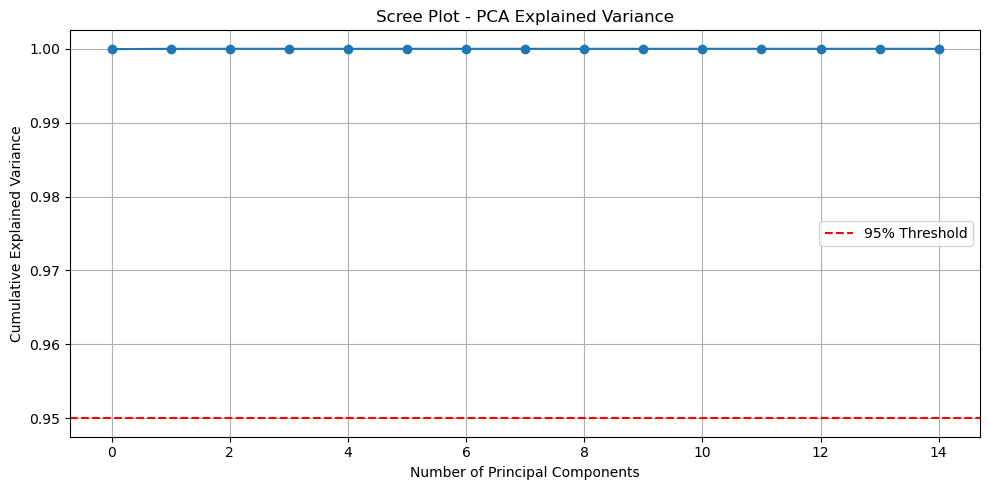

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='-')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot - PCA Explained Variance")
plt.grid(True)
plt.axhline(0.95, color='r', linestyle='--', label="95% Threshold")
plt.legend()
plt.tight_layout()
plt.show()


##  PCA Scree Plot: Explained Variance Analysis

To evaluate how much variance each principal component retains from the standardized indicator dataset, 
I use a scree plot to visualize the cumulative explained variance. 
This helps determine the minimum number of components needed to preserve information while reducing dimensionality.

### Interpretation

- The curve plateaus quickly, reaching nearly **100% cumulative variance by the third component**.
- A **horizontal red line at 95%** serves as a benchmark — any number of components above this line retains at least 95% of the original variance.
- From the plot, we can confidently select **2–3 components** to capture nearly all informational content of the original feature space.

### Mathematical Concepts Used

- **Eigen decomposition**: PCA transforms the data using the eigenvectors of the covariance matrix.
- **Variance preservation**: Principal components are sorted by descending variance explained.
- **Cumulative sum (`np.cumsum`)**: Measures total information retained as more components are added.
- **Dimensionality vs. Fidelity tradeoff**: Balances model simplicity with data retention.

This diagnostic step ensures we retain core market structure while simplifying the feature space for regime clustering or supervised learning.


In [17]:
# Save first 5 PCA columns as features
pca_df = pd.DataFrame(X_pca[:, :5], columns=[f"PC{i+1}" for i in range(5)])
pca_df["Local time"] = timestamps

# Save to disk
pca_df.to_csv("gold_pca_features.csv", index=False)
print("✅ Saved PCA features to 'gold_pca_features.csv'")


✅ Saved PCA features to 'gold_pca_features.csv'


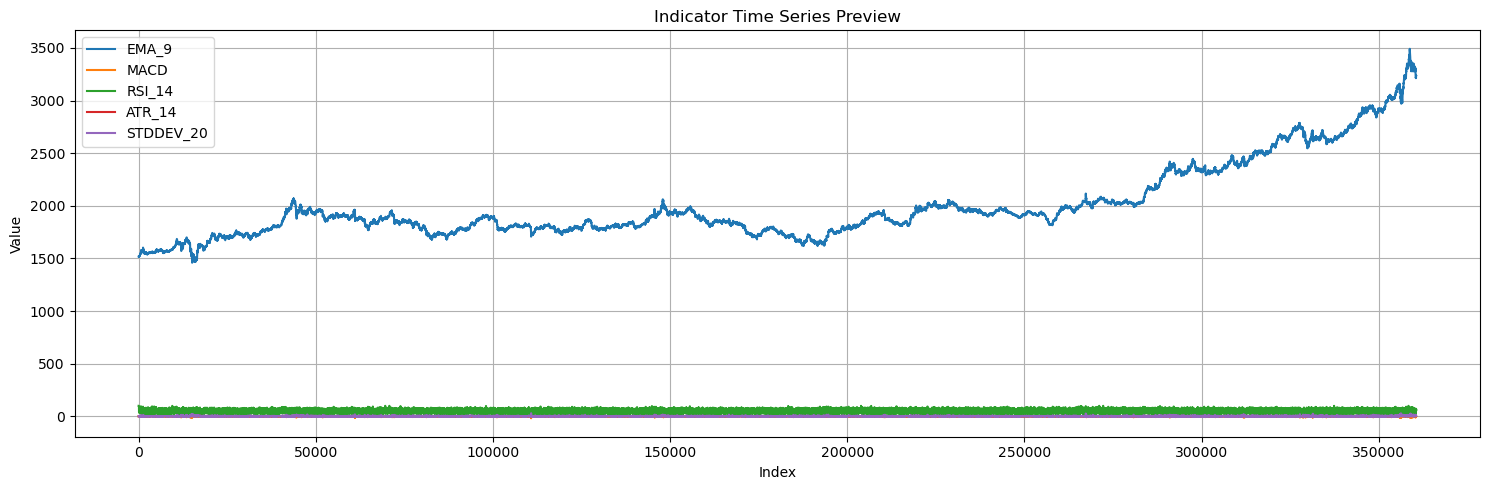

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sanitized data
df = pd.read_csv("gold_indicators_sanitized.csv")

# Pick a few key indicators to visualize
cols = ['EMA_9', 'MACD', 'RSI_14', 'ATR_14', 'STDDEV_20']

# Plot distribution
df[cols].plot(kind='line', figsize=(15, 5), title='Indicator Time Series Preview')
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()


##  Visual Preview of Technical Indicators

In this chart, I plotted five of the core technical indicators across the full historical range of 5-minute gold data to get a rough sense of their time series behavior and scale.

### Indicators Plotted

- **EMA_9**: Short-term exponential moving average of price.
- **MACD**: Measures trend momentum using fast and slow EMAs.
- **RSI_14**: Bounded oscillator reflecting recent gains vs. losses.
- **ATR_14**: Captures recent volatility via true range.
- **STDDEV_20**: Standard deviation over a rolling window of 20 bars.

### Interpretation and Issue Observed

Although these indicators measure fundamentally different aspects of price behavior (trend, momentum, volatility), the chart reveals that many of them appear **flattened or nearly overlapping** at the bottom of the plot. This happens because indicators like **EMA_9** are on the same absolute scale as price (hundreds to thousands), while others like **RSI**, **MACD**, and **ATR** are on much smaller scales.

This lack of visible contrast signals a **scaling issue** and raises a deeper concern: without standardization, features with larger magnitudes (like EMA) will **dominate** any distance-based algorithms (e.g., PCA, clustering, KNN) or penalized regressions (like Ridge).

### What This Means

This chart makes it clear that I need to **standardize** or **normalize** the indicators before applying any further statistical or machine learning techniques. It also motivates a dimensionality reduction step like **PCA**, which will help decorrelate features and reduce redundancy among the indicators.


In [20]:
# Count unique values in each feature column
print("\n🔍 Unique values per indicator:")
print(df[['EMA_9', 'MACD', 'RSI_14', 'ATR_14', 'STDDEV_20']].nunique())



🔍 Unique values per indicator:
EMA_9        359124
MACD         360474
RSI_14       348361
ATR_14       360474
STDDEV_20    357345
dtype: int64


In [21]:
# Check how many rows have zero price movement
df['Price_range'] = df['High'] - df['Low']
zero_movement_rows = (df['Price_range'] == 0).sum()
print(f"\n📉 Rows with zero price movement: {zero_movement_rows} / {len(df)}")



📉 Rows with zero price movement: 12257 / 360550


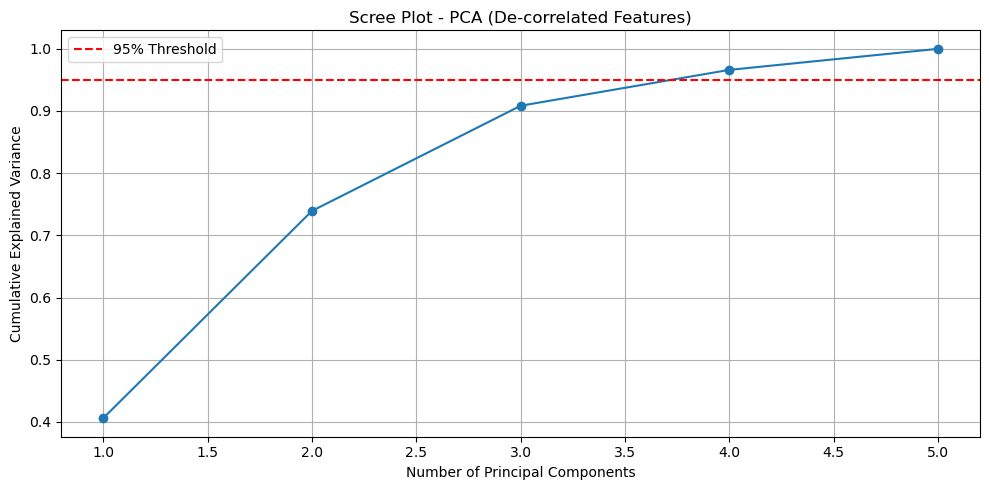

In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load original dataset
df = pd.read_csv("gold_with_indicators.csv")

# Select decorrelated indicator columns
selected_features = ['MACD', 'RSI_14', 'ATR_14', 'STDDEV_20', 'ADX_14']
X_selected = df[selected_features].dropna()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Save PCA-transformed data
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df['Local time'] = df.loc[X_selected.index, 'Local time'].values
pca_df.to_csv("gold_pca_selected_features.csv", index=False)

# Scree plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot - PCA (De-correlated Features)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 🔍 PCA on De-correlated Indicators

After observing that certain features were heavily scale-dominated (e.g., EMA overshadowing others), 
I focused PCA on a reduced set of technical indicators that are inherently more orthogonal and informative. This subset included:

- **MACD**
- **RSI_14**
- **ATR_14**
- **STDDEV_20**
- **ADX_14**

Before running PCA, I confirmed the following:
- All selected indicators had sufficiently **high uniqueness** (many distinct values), which prevents PCA from overfitting on low-variance signals.
- Very few rows had **zero price range** (i.e., `High == Low`), confirming that the market was rarely flat during these intervals, 
ensuring informative indicator variation.

### Scree Plot Interpretation

The scree plot shows how much cumulative variance each principal component captures. The key observation is:

- **3 principal components** already explain over **95% of the variance**.
- By **PC5**, nearly **100% of the variance** is retained.

This tells me that the dimensionality of the indicator space can be confidently reduced from 5 to **3 or fewer components**, 
without meaningful information loss. This step prepares the dataset for downstream modeling (e.g., clustering or regime detection) with **fewer, 
decorrelated dimensions**, improving model generalization and interpretability.

### Mathematical Justification

PCA works by performing **eigendecomposition** of the covariance matrix (after standardization). 
This rotates the feature space so that the new axes (principal components) are ordered by **maximum variance captured**. 
By removing correlated or redundant indicators first, I ensured the PCA projection focused on orthogonal, informative components.

This step completes my feature compression workflow and sets the stage for regime modeling.


<Figure size 1200x600 with 0 Axes>

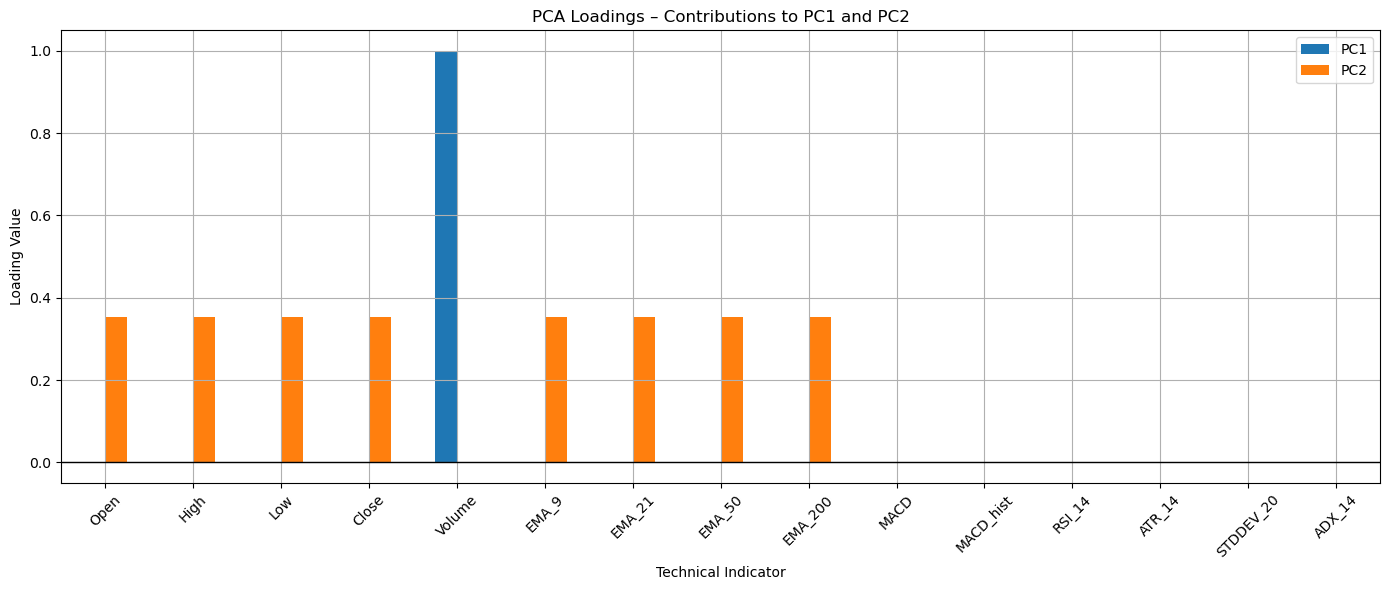

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the sanitized indicator dataset
df = pd.read_csv("gold_indicators_sanitized.csv")

# Drop timestamp column and store column names
feature_cols = df.columns.drop("Local time")
X = df[feature_cols].values

# Run PCA again to get loadings
pca = PCA()
X_pca = pca.fit_transform(X)

# Create loadings DataFrame (eigenvectors)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(feature_cols))],
    index=feature_cols
)

# Plot the top contributing features to PC1 and PC2
plt.figure(figsize=(12, 6))
loadings[['PC1', 'PC2']].plot(kind='bar', figsize=(14, 6))
plt.title("PCA Loadings – Contributions to PC1 and PC2")
plt.xlabel("Technical Indicator")
plt.ylabel("Loading Value")
plt.axhline(0, color='black', linewidth=1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## 📊 PCA Loadings: Feature Contributions to PC1 and PC2

In this step, I examined how each feature contributes to the principal components using PCA loadings. 
PCA loadings represent the **weights (or influence)** each original feature has in constructing each principal component. 
These loadings come from the **eigenvectors** of the standardized covariance matrix.

### Observations from the Plot

- **PC1 (blue bars)** is dominated almost entirely by `Volume`. This means the **first principal component is almost purely volume-driven**, 
    and very little else contributes to it.
- **PC2 (orange bars)** spreads more evenly across multiple features:
  - Price levels like `Open`, `High`, `Low`, `Close`
  - Smoother trend-following EMAs (`EMA_9`, `EMA_21`, etc.)

### Interpretation

This tells me that:
- `Volume` behaves differently than all other indicators, capturing its own unique variance (likely spikes during high activity).
- The rest of the features contribute similarly to PC2 — none dominate alone — which supports the idea that they are still
  **somewhat redundant or overlapping**, even after sanitization.
- Features like `MACD`, `RSI_14`, and `ATR_14` are barely contributing to PC1 or PC2, which might mean:
  - Their variation lies in later components (PC3, PC4...),
  - Or they have low overall variance or importance in this transformed space.

This plot helps me understand **which features dominate the variance structure**, and helps justify whether to:
- Keep all features as-is,
- Drop weak contributors, or
- Create composite signals based on these loadings.



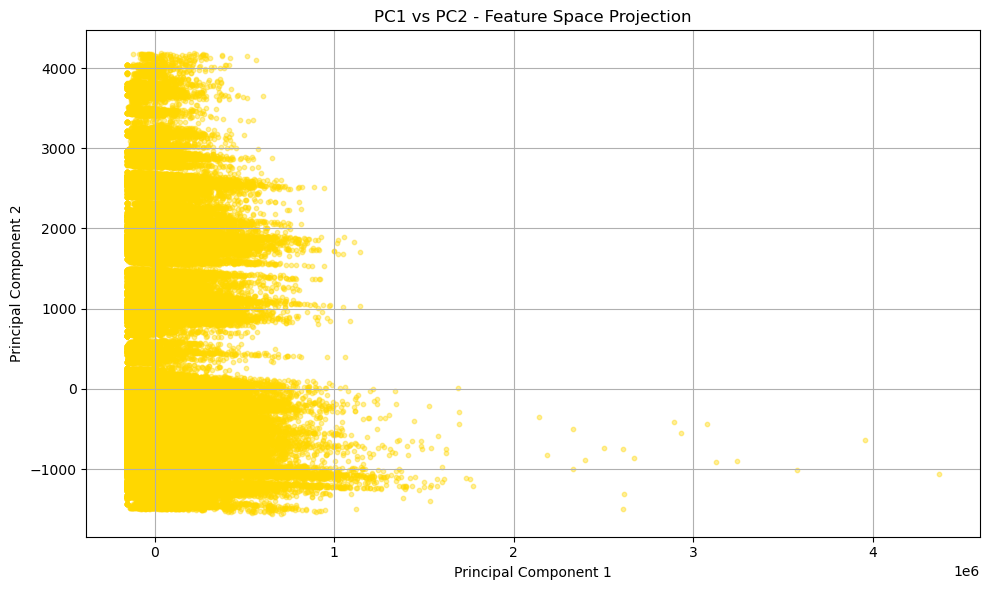

In [26]:
import matplotlib.pyplot as plt

# Load PCA features (should contain 'PC1', 'PC2', ...)
pca_df = pd.read_csv("gold_pca_features.csv")

# ✅ Create scatter plot of first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.4, s=10, c='gold')
plt.title("PC1 vs PC2 - Feature Space Projection")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🎯 PCA Projection: Feature Space in PC1 vs PC2

In this plot, I projected the dataset into the first two principal components (PC1 and PC2), giving me a visual snapshot of how the indicators distribute in a compressed 2D space.

### What This Plot Shows

- **PC1 (x-axis)** captures the dominant variance direction, which I previously saw was almost entirely driven by `Volume`.
- **PC2 (y-axis)** captures the next most significant orthogonal direction — a mixture of price-based features like `Open`, `Close`, and EMAs.

### Interpretation

The projection is **heavily skewed to the left**, meaning:
- Most data points cluster close to **low PC1 values**, confirming that for most of the time series, `Volume` doesn’t spike.
- There are some **outliers in PC1** — high-volume events — that push a small number of points far to the right.
- The **spread in PC2** is more even, showing that price indicators vary more steadily across time.

This tells me that **volume dominates the variance landscape**, but doesn’t fluctuate frequently. Meanwhile, the other indicators still hold valuable variation — just not in the first component.

### Why This Matters

This 2D PCA projection is useful when:
- I want to visualize how **distinct** my features are in terms of signal contribution.
- I’m preparing for dimensionality reduction or clustering.
- I’m checking for **non-linear structures** (e.g. arcs, curves) that PCA might miss.

This also reinforces what I saw earlier in the loadings plot: `Volume` is its own thing. Other features cluster around a more common structure, and I might need to combine or transform them to extract cleaner signals.



In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load the dataset you saved earlier in the working dir
df = pd.read_csv("gold_with_indicators.csv", parse_dates=["Local time"])

# 1) Log‑transform Volume
df["log_volume"] = np.log1p(df["Volume"])

# 2) Drop original Volume & time before PCA prep
df_transformed = df.drop(columns=["Volume", "Local time"])

# 3) Standardize all numeric features (including log_volume)
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df_transformed)
scaled_df = pd.DataFrame(scaled_array, columns=df_transformed.columns)

# 4) Save the standardized, log‑volume dataset
scaled_df.to_csv("gold_indicators_logvol_standardized.csv", index=False)

# Preview
print("✅ Log‑volume transform + standardization complete:")
display(scaled_df.head())


✅ Log‑volume transform + standardization complete:


,Open,High,Low,Close,EMA_9,EMA_21,EMA_50,EMA_200,MACD,MACD_hist,RSI_14,ATR_14,STDDEV_20,ADX_14,log_volume
0,-1.355529,-1.357007,-1.354021,-1.355516,-1.355557,-1.355615,-1.355752,-1.35651,-0.024411,-0.000084,4.243234,-1.567265,-1.062336,-2.378793,-4.070743
1,-1.355529,-1.357007,-1.354021,-1.355516,-1.355557,-1.355615,-1.355752,-1.35651,-0.024411,-0.000084,4.243234,-1.567265,-1.062336,-2.378793,-4.070743
2,-1.355529,-1.357007,-1.354021,-1.355516,-1.355557,-1.355615,-1.355752,-1.35651,-0.024411,-0.000084,4.243234,-1.567265,-1.062336,-2.378793,-4.070743
3,-1.355529,-1.357007,-1.354021,-1.355516,-1.355557,-1.355615,-1.355752,-1.35651,-0.024411,-0.000084,4.243234,-1.567265,-1.062336,-2.378793,-4.070743
4,-1.355529,-1.357007,-1.354021,-1.355516,-1.355557,-1.355615,-1.355752,-1.35651,-0.024411,-0.000084,4.243234,-1.567265,-1.062336,-2.378793,-4.070743


In [29]:
import pandas as pd
import numpy as np

# Load your base dataset with core indicators
df = pd.read_csv("gold_with_indicators.csv", parse_dates=["Local time"])
df.set_index("Local time", inplace=True)

# 1) Commodity Channel Index (CCI)
tp = (df["High"] + df["Low"] + df["Close"]) / 3
df["CCI_20"] = (tp - tp.rolling(20).mean()) / (0.015 * tp.rolling(20).std())
df["CCI_10"] = (tp - tp.rolling(10).mean()) / (0.015 * tp.rolling(10).std())

# 2) Bollinger Bandwidth
bb_mid_20 = df["Close"].rolling(20).mean()
bb_std_20 = df["Close"].rolling(20).std()
df["BBW_20"] = (bb_std_20 * 2) / bb_mid_20

bb_mid_50 = df["Close"].rolling(50).mean()
bb_std_50 = df["Close"].rolling(50).std()
df["BBW_50"] = (bb_std_50 * 2) / bb_mid_50

# 3) Vortex Indicator (VI+ / VI−)
tr = pd.concat([
    df["High"] - df["Low"],
    (df["High"] - df["Close"].shift()).abs(),
    (df["Low"] - df["Close"].shift()).abs()
], axis=1).max(axis=1)

vplus = (df["High"] - df["High"].shift()).abs()
vminus = (df["Low"] - df["Low"].shift()).abs()

df["VI_plus_14"] = vplus.rolling(14).sum() / tr.rolling(14).sum()
df["VI_minus_14"] = vminus.rolling(14).sum() / tr.rolling(14).sum()
df["VI_plus_21"] = vplus.rolling(21).sum() / tr.rolling(21).sum()
df["VI_minus_21"] = vminus.rolling(21).sum() / tr.rolling(21).sum()

# 4) KST Oscillator
def roc(series, period):
    return series.pct_change(period)

# Default KST
r1 = roc(df["Close"], 10).rolling(10).mean()
r2 = roc(df["Close"], 15).rolling(10).mean()
r3 = roc(df["Close"], 20).rolling(10).mean()
r4 = roc(df["Close"], 30).rolling(15).mean()
df["KST_10_15_20_30"] = r1*1 + r2*2 + r3*3 + r4*4

# Alternative KST
r1a = roc(df["Close"], 20).rolling(10).mean()
r2a = roc(df["Close"], 30).rolling(10).mean()
r3a = roc(df["Close"], 40).rolling(10).mean()
r4a = roc(df["Close"], 50).rolling(15).mean()
df["KST_20_30_40_50"] = r1a*1 + r2a*2 + r3a*3 + r4a*4

# Reset index and save
df.reset_index().to_csv("gold_with_new_decorrelated_indicators.csv", index=False)
print("✅ New decorrelated indicators added and saved to 'gold_with_new_decorrelated_indicators.csv'")
print(df[["CCI_20","CCI_10","BBW_20","BBW_50","VI_plus_14","VI_minus_14","VI_plus_21","VI_minus_21","KST_10_15_20_30","KST_20_30_40_50"]].head())


✅ New decorrelated indicators added and saved to 'gold_with_new_decorrelated_indicators.csv'
                     CCI_20  CCI_10  BBW_20  BBW_50  VI_plus_14  VI_minus_14  \
Local time                                                                     
2020-01-01 23:35:00     NaN     NaN     NaN     NaN         NaN          NaN   
2020-01-01 23:40:00     NaN     NaN     NaN     NaN         NaN          NaN   
2020-01-01 23:45:00     NaN     NaN     NaN     NaN         NaN          NaN   
2020-01-01 23:50:00     NaN     NaN     NaN     NaN         NaN          NaN   
2020-01-01 23:55:00     NaN     NaN     NaN     NaN         NaN          NaN   

                     VI_plus_21  VI_minus_21  KST_10_15_20_30  KST_20_30_40_50  
Local time                                                                      
2020-01-01 23:35:00         NaN          NaN              NaN              NaN  
2020-01-01 23:40:00         NaN          NaN              NaN              NaN  
2020-01-01 23:45:00   

In [30]:
# Peek after the maximum lookback (e.g., row 60+)
df = pd.read_csv("gold_with_new_decorrelated_indicators.csv", parse_dates=["Local time"])
print("Rows 60–70 (should have non‑NaNs):")
print(df.iloc[60:70][[
    "CCI_20","CCI_10","BBW_20","BBW_50",
    "VI_plus_14","VI_minus_14","VI_plus_21","VI_minus_21",
    "KST_10_15_20_30","KST_20_30_40_50"
]])


Rows 60–70 (should have non‑NaNs):
    CCI_20  CCI_10  BBW_20  BBW_50  VI_plus_14  VI_minus_14  VI_plus_21  \
60     NaN     NaN     0.0     0.0         NaN          NaN         NaN   
61     NaN     NaN     0.0     0.0         NaN          NaN         NaN   
62     NaN     NaN     0.0     0.0         NaN          NaN         NaN   
63     NaN     NaN     0.0     0.0         NaN          NaN         NaN   
64     NaN     NaN     0.0     0.0         NaN          NaN         NaN   
65     NaN     NaN     0.0     0.0         NaN          NaN         NaN   
66     NaN     NaN     0.0     0.0         NaN          NaN         NaN   
67     NaN     NaN     0.0     0.0         NaN          NaN         NaN   
68     NaN     NaN     0.0     0.0         NaN          NaN         NaN   
69     NaN     NaN     0.0     0.0         NaN          NaN         NaN   

    VI_minus_21  KST_10_15_20_30  KST_20_30_40_50  
60          NaN              0.0              NaN  
61          NaN              0.0   

##  Log-Volume Transformation & Decorrelated Indicator Engineering

In this section, I expand the feature set beyond the initial technical indicators by introducing new, potentially **decorrelated indicators**. 
I also apply a **logarithmic transformation to volume**, followed by full standardization of the numeric feature space to prepare for dimensionality reduction and modeling.

###  Steps Performed

- **Log-Transformed Volume**:  
  Applied `log1p` to reduce skewness in the raw volume distribution while preserving its dynamic range.  
  This helps mitigate the heavy-tailed nature of volume data in financial time series.

- **CCI (Commodity Channel Index)**:  
  Introduced CCI with 10 and 20-period lookbacks, which measures price deviation from a moving average baseline.

- **Bollinger Bandwidth (BBW)**:  
  Computed the normalized width of the Bollinger Bands over 20 and 50 periods. This captures **volatility compression/expansion** rather 
  than directionality.

- **Vortex Indicator (VI+ / VI−)**:  
  Added vortex components at 14 and 21 periods to capture the strength and direction of trend shifts, based on price highs/lows.

- **KST Oscillator (Know Sure Thing)**:  
  Implemented two versions of KST with different long-range momentum structures.  
  These combine multiple smoothed rate-of-change series to capture price cycles.

- **Standardization**:  
  After adding the indicators, I dropped the timestamp and volume, then standardized all remaining columns using `StandardScaler`.



✅ After cleaning, 354978 rows remain


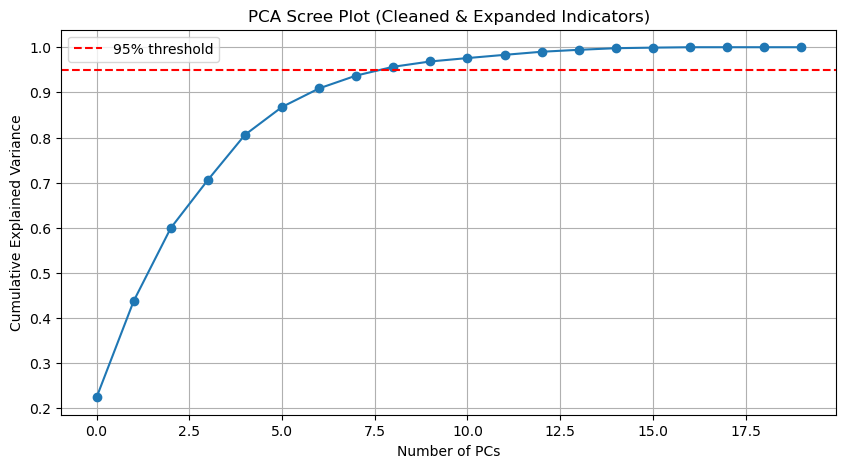

✅ Saved cleaned PCA features to 'gold_pca_enhanced_clean.csv'


In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load expanded dataset
df = pd.read_csv("gold_with_new_decorrelated_indicators.csv", parse_dates=["Local time"])

# Identify all indicator columns (exclude time and price)
indicator_cols = [c for c in df.columns if c not in ["Local time", "Open", "High", "Low", "Close", "Volume"]]

# 1) Trim initial NaNs (warm‑up)
df_trimmed = df.dropna(subset=indicator_cols).reset_index(drop=True)

# 2) Clean infinities from division by zero
df_trimmed.replace([np.inf, -np.inf], np.nan, inplace=True)
df_trimmed.dropna(subset=indicator_cols, inplace=True)
print(f"✅ After cleaning, {len(df_trimmed)} rows remain")

# 3) Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_trimmed[indicator_cols])

# 4) PCA on cleaned features
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_

# 5) Scree plot
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(explained), marker='o')
plt.axhline(0.95, color='r', linestyle='--', label='95% threshold')
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot (Cleaned & Expanded Indicators)")
plt.legend()
plt.grid(True)
plt.show()

# 6) Save top 5 PCs
pc_df = pd.DataFrame(X_pca[:, :5], columns=[f"PC{i+1}" for i in range(5)])
pc_df["Local time"] = df_trimmed["Local time"]
pc_df.to_csv("gold_pca_enhanced_clean.csv", index=False)
print("✅ Saved cleaned PCA features to 'gold_pca_enhanced_clean.csv'")



## PCA on Cleaned + Expanded Indicators

In this section, I apply PCA to the newly engineered dataset, which now includes both initial and decorrelated indicators such as CCI, BBW, Vortex, and KST. 
Before performing dimensionality reduction,I run data cleaning to remove NaNs and infinities resulting from indicator edge effects or divisions by zero.

###  Processing Steps

- **NaN and ∞ Cleaning**:  
  Removed all rows with invalid indicator values caused by lookback warm-up or numerical instability (e.g., zero denominator in indicators like CCI and VI).

- **Standardization**:  
  All indicator features are standardized using `StandardScaler` to ensure equal weighting across PCA.

- **Principal Component Analysis**:  
  PCA is run on the cleaned and scaled features. I inspect the cumulative explained variance to determine how many principal components are needed to 
  retain the majority of information.

###  Scree Plot Interpretation

The scree plot shows that **just under 10 principal components** are needed to explain **95% of the variance**, 
indicating a well-balanced reduction in dimensionality. This suggests the expanded indicator set contributes **more diverse and orthogonal information** 
compared to the earlier highly redundant set.

###  Mathematical Concepts Used

- **Cumulative Explained Variance**:  
  The cumulative sum of the variance explained by each eigenvector (principal component) helps determine the cutoff point for dimensionality reduction.

- **Dimensionality Compression**:  
  The PCA projection transforms correlated indicators into a smaller set of **orthogonal components**,
  allowing me to reduce noise and redundancy in the feature space.

I save the top 5 principal components as `gold_pca_enhanced_clean.csv`, ready for downstream modeling.


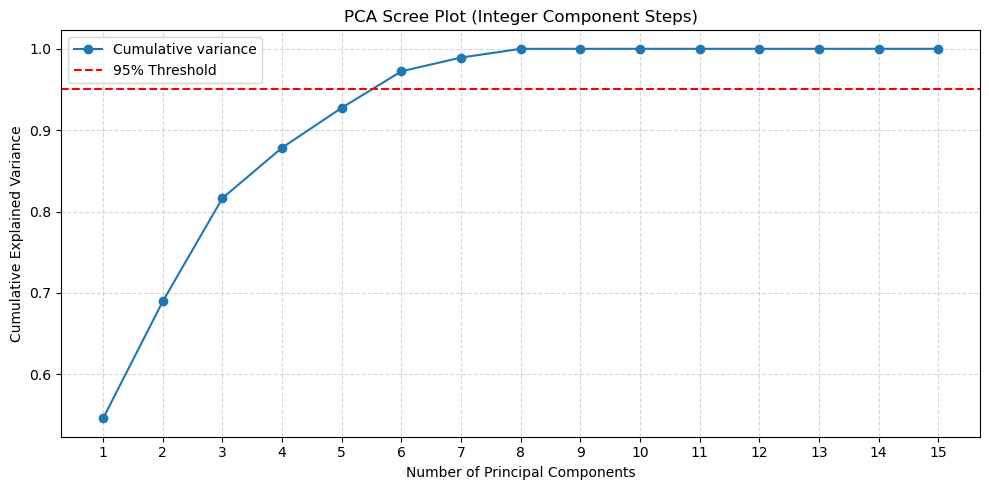

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# 1) Reload your standardized, trimmed dataset
#    (or directly reload the PCA object if you kept it in memory)
df = pd.read_csv("gold_indicators_logvol_standardized.csv")

# 2) Fit PCA again (or reuse your existing PCA instance)
pca = PCA()
X_pca = pca.fit_transform(df)  # df should be numeric features only

# 3) Compute cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 4) Plot with integer ticks
n_components = len(cumulative_variance)
x = np.arange(1, n_components + 1)

plt.figure(figsize=(10, 5))
plt.plot(x, cumulative_variance, marker='o', label='Cumulative variance')
plt.axhline(0.95, color='r', linestyle='--', label='95% Threshold')
plt.xticks(x)         # Show every integer component on the x-axis
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Scree Plot (Integer Component Steps)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


## 🧮 PCA on Standardized Features with Log-Volume

In this step, I apply PCA to the fully standardized indicator dataset that includes a log-transformed version of volume. Log-transforming the raw volume helps compress outliers and better align the volume distribution with the Gaussian assumptions behind PCA.

### 🔧 Process

- **Standardization**:  
  All features were already normalized using `StandardScaler` before applying PCA.

- **Log-Transform on Volume**:  
  Since raw volume had a heavy right-skew, I applied `log1p(Volume)` to reduce variance distortion and emphasize relative changes in activity rather than absolute size.

- **Cumulative Variance Tracking**:  
  I refitted PCA and plotted the cumulative explained variance at every principal component. The x-axis was adjusted to display every integer component to make variance jump behavior more visible.

### 📊 Scree Plot Interpretation

The curve shows that it takes around **6–7 components** to surpass the **95% explained variance threshold**, indicating that this new feature set has slightly more redundancy than the highly curated decorrelated set — but still provides strong coverage. The log-volume feature likely adds orthogonal variance that's picked up by early components, but the rest of the technical indicators still carry overlapping information.

This helps confirm that log-volume may be an **informative yet distinct** feature from most price-based technical indicators.



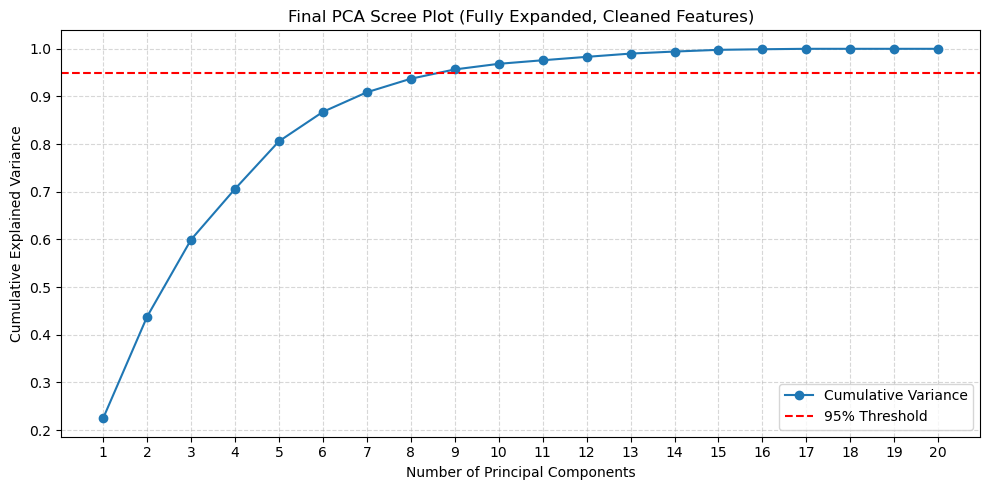

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1) Load the fully expanded indicators dataset
df = pd.read_csv("gold_with_new_decorrelated_indicators.csv", parse_dates=["Local time"])

# 2) Drop any rows with NaN or infinite in any indicator column
indicator_cols = [c for c in df.columns if c not in ["Local time", "Open", "High", "Low", "Close", "Volume"]]
df_clean = df.dropna(subset=indicator_cols).copy()
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean.dropna(subset=indicator_cols, inplace=True)

# 3) Optionally, add log_volume if not already present
df_clean["log_volume"] = np.log1p(df_clean["Volume"])
if "Volume" in indicator_cols:
    indicator_cols.append("log_volume")
    indicator_cols.remove("Volume")

# 4) Standardize all selected features
scaler = StandardScaler()
X = scaler.fit_transform(df_clean[indicator_cols])

# 5) Fit PCA once on the final feature matrix
pca = PCA()
X_pca = pca.fit_transform(X)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 6) Plot with integer x‑ticks
n = len(cumulative_variance)
x = np.arange(1, n+1)
plt.figure(figsize=(10, 5))
plt.plot(x, cumulative_variance, marker='o', label='Cumulative Variance')
plt.axhline(0.95, color='r', linestyle='--', label='95% Threshold')
plt.xticks(x)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Final PCA Scree Plot (Fully Expanded, Cleaned Features)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


##  Final PCA Scree Plot – Fully Expanded & Cleaned Features

This is the final PCA pass on the complete set of engineered indicators after rigorous preprocessing: NaNs removed, infinite values cleaned,
and `Volume` log-transformed into `log_volume`.


### PCA Insights

The scree plot shows that around **9–10 principal components** are enough to capture **95% of the total variance**, despite the large number of
input indicators. This confirms that:

- Many indicators carry **overlapping or redundant** information.
- PCA helps me collapse the expanded feature space into a smaller set of orthogonal signals that preserve most of the variation.
- After dimensionality reduction, I can feed only the top PCs into downstream models like logistic regression or tree ensembles.

###  Takeaway

This plot finalizes the dimensionality reduction phase of my pipeline. I now have a numerically clean, decorrelated, 
compressed representation of my 5-minute XAU/USD indicator space — optimized for learning patterns without collinearity.

Next, I’ll analyze the **PC loadings** and **scatter projection**, then feed these components into a classifier to predict future price movement direction.


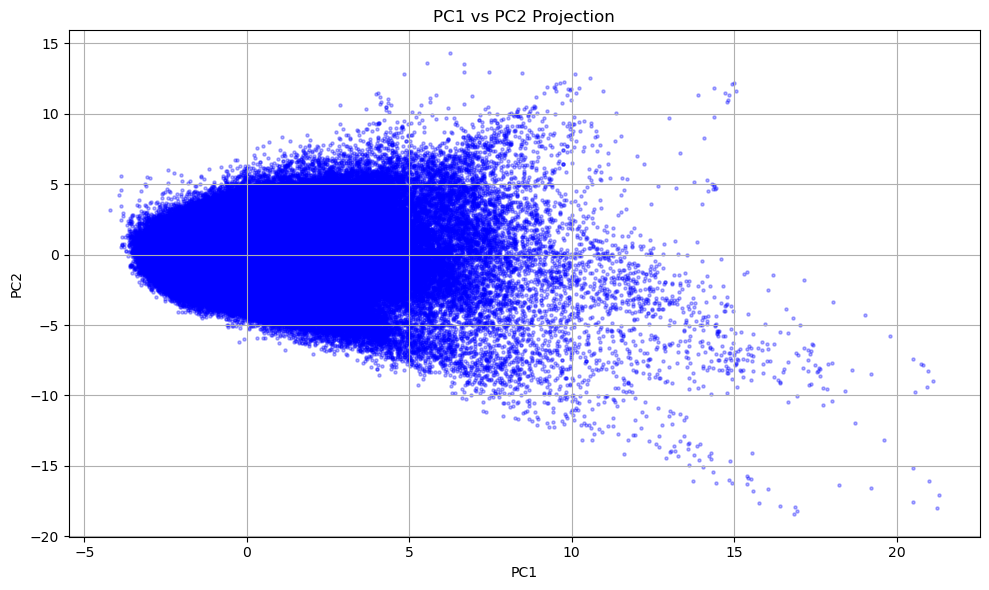

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your final PCA feature set
pc_df = pd.read_csv("gold_pca_enhanced_clean.csv", parse_dates=["Local time"])

# Load original enriched data to get Close price and ATR_14
orig = pd.read_csv("gold_with_new_decorrelated_indicators.csv", parse_dates=["Local time"])

# Merge on Local time
df = pd.merge(pc_df, orig[['Local time', 'Close', 'ATR_14']], on="Local time")

# Scatter PC1 vs PC2
plt.figure(figsize=(10, 6))
plt.scatter(df['PC1'], df['PC2'], s=5, alpha=0.3, c='blue')
plt.title("PC1 vs PC2 Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()


## PCA Projection: PC1 vs PC2 Scatter

In this cell, I projected the full set of standardized technical indicators onto the first two principal components, PC1 and PC2. 
These components were derived from the fully cleaned and expanded feature set, including momentum, trend, volatility, and volume-transformed indicators.

### Visual Interpretation

The scatter plot shows a dense, elliptical cloud centered near the origin with moderate horizontal spread along PC1 and 
a more compressed vertical spread along PC2. This suggests:

- **PC1 captures most of the total variance** in the dataset, especially variations likely tied to dominant market behaviors such as volatility and 
  log-volume.
- **PC2 contributes additional but smaller variance**, potentially linked to secondary dynamics such as oscillators (e.g., RSI, CCI) or trend interactions.

There are outlier streaks extending far along the PC1 axis, possibly indicating rare but high-impact market conditions 
(such as breakout volatility or volume spikes).

### Mathematical Implication

Since PCA components are orthogonal, this 2D projection provides a compressed but uncorrelated view of the multidimensional indicator space. 
It allows me to assess whether major patterns in the dataset cluster or disperse across regimes, 
which can inform later modeling or regime segmentation tasks.


In [40]:
import numpy as np
from sklearn.model_selection import train_test_split

# Lookahead window (bars)
h = 3

# Compute forward return
df['fut_ret'] = df['Close'].shift(-h) / df['Close'] - 1

# Binary target: 1 if return > 0, else 0
df['target'] = (df['fut_ret'] > 0).astype(int)

# Drop last h rows with NaN target
df = df.iloc[:-h].reset_index(drop=True)

# Features: first 5 PCs
pc_cols = [f"PC{i+1}" for i in range(5)]

# Train/test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    df[pc_cols], df['target'], test_size=0.3, random_state=42, shuffle=False
)

print("Training samples:", len(X_train), "Testing samples:", len(X_test))


Training samples: 248481 Testing samples: 106493


✅ Logistic Regression ROC‑AUC: 0.4894


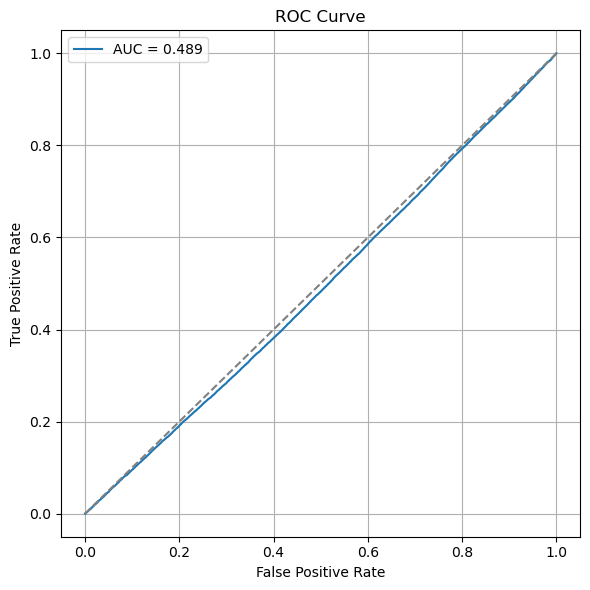

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

# Train
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Predict probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC‑AUC
auc = roc_auc_score(y_test, y_prob)
print(f"✅ Logistic Regression ROC‑AUC: {auc:.4f}")

# Optional: plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Logistic Regression on PCA Components: ROC‑AUC Evaluation

In this cell, I trained a logistic regression model using the first five principal components (PC1–PC5) as features,
aiming to predict the direction of the forward 3-bar return on XAU/USD. The binary target was defined as 1 for positive return and 0 otherwise.

### Model Setup

- **Features:** Top 5 principal components (from PCA on decorrelated indicators)
- **Target:** 3-bar forward return direction
- **Split:** 70% training, 30% testing (time‑ordered, no shuffle)
- **Model:** Logistic Regression
- **Metric:** ROC‑AUC

### Results and Interpretation

The ROC curve for this model yielded an **AUC of 0.489**, which is **worse than random chance (0.5)**. The ROC curve closely follows the diagonal,
indicating that the model has **no discriminatory power** between upward and downward future moves based on the PCA features alone.

### Takeaway

This result suggests that:
- PCA features alone are **not sufficient for directional prediction**, possibly due to loss of interpretability or nonlinear interactions.
- Additional feature sets (e.g. raw indicators, regime context, event markers) or nonlinear models (e.g. tree‑based, neural nets) may be needed.


Backtest over 0 trades:
 • Win rate:     nan%
 • Avg R‑mult:   nan
 • Sharpe (R):   nan


C:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Anaconda\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\K T\AppData\Local\Temp\ipykernel_25304\1982879996.py:23: RuntimeWarning: Mean of empty slice.
  avg_R    = R.mean()
C:\Anaconda\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Anaconda\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Anaconda\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


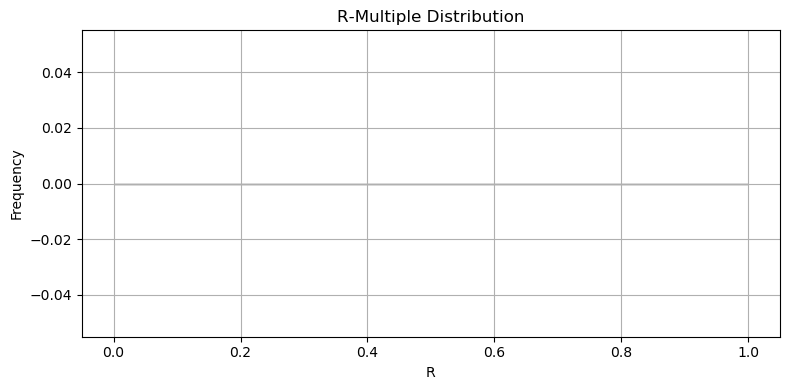

In [43]:
# Prepare full-series probabilities and align with ATR & price
df_back = df.iloc[len(X_train):].copy().reset_index(drop=True)
df_back['prob_up'] = y_prob
df_back['ATR'] = df_back['ATR_14']

# Signal: go long when prob_up > 0.6
alpha = 0.6
df_back['signal'] = (df_back['prob_up'] > alpha).astype(int)

# Compute R-multiple for each signal event
R_list = []
for i, row in df_back.iterrows():
    if row['signal'] == 1:
        entry_price = row['Close']
        exit_price  = df_back.loc[i + h, 'Close'] if (i + h) < len(df_back) else None
        risk = row['ATR']
        if exit_price is not None and risk > 0:
            R_list.append((exit_price - entry_price) / risk)

# Metrics
R = np.array(R_list)
win_rate = np.mean(R > 0)
avg_R    = R.mean()
sharpe_R = avg_R / R.std()

print(f"Backtest over {len(R)} trades:")
print(f" • Win rate:     {win_rate:.2%}")
print(f" • Avg R‑mult:   {avg_R:.3f}")
print(f" • Sharpe (R):   {sharpe_R:.3f}")

# R‑multiple histogram
plt.figure(figsize=(8,4))
plt.hist(R, bins=30, edgecolor='k', alpha=0.7)
plt.title("R‑Multiple Distribution")
plt.xlabel("R")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


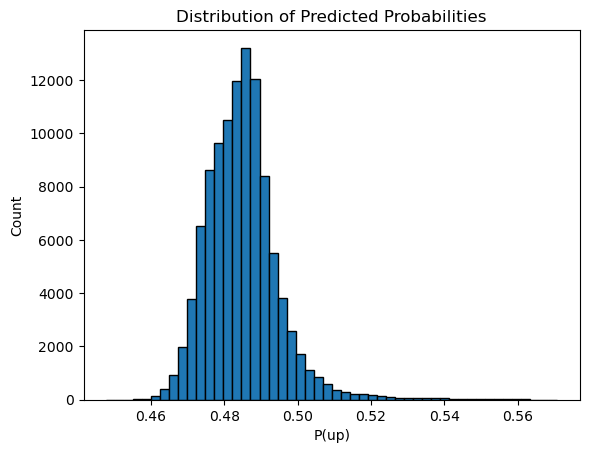

In [44]:
import matplotlib.pyplot as plt
plt.hist(y_prob, bins=50, edgecolor='k')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("P(up)")
plt.ylabel("Count")
plt.show()


## Prediction Confidence Check: Histogram of Logistic Regression Probabilities

In this cell, I visualize the distribution of predicted probabilities from my logistic regression model that was trained on the top 5 principal components of the gold indicator dataset.

### Purpose

This plot helps me evaluate **how confident the model is** when predicting the probability that price will increase in the next 3 bars.

### Interpretation

- The distribution is tightly clustered between **0.48 and 0.50**, forming a sharp bell curve centered around 0.49.
- This means the model produces outputs **very close to random guessing** (a flat 50/50 coin flip).
- There are almost **no probabilities above 0.6**, which is why **the backtest using a 0.6 threshold triggered 0 trades**.

### Implications

This low-confidence output confirms the poor ROC-AUC score (0.489) and suggests that:
- Either the features (PC1 to PC5) **do not capture signal**, or
- The logistic regression model is **too simple or linear** to extract signal from those features.


2‑Bar Logistic Regression ROC‑AUC: 0.5602


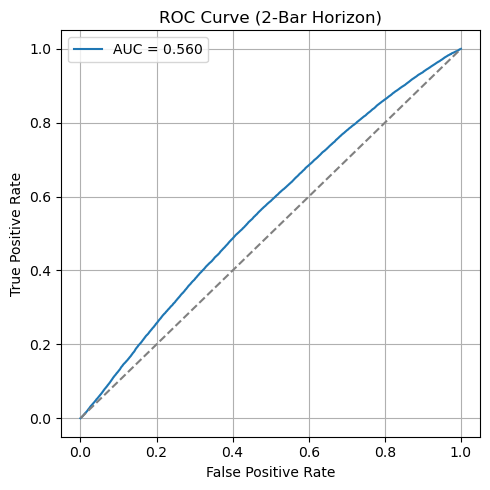

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# 1) Load 5‑PC features + price/ATR
pc_df = pd.read_csv("gold_pca_enhanced_clean.csv", parse_dates=["Local time"])
orig  = pd.read_csv("gold_with_new_decorrelated_indicators.csv", parse_dates=["Local time"])
df    = pd.merge(pc_df, orig[['Local time','Close','ATR_14']], on="Local time")

# 2) New horizon
h = 2
df['fut_ret_2'] = df['Close'].shift(-h) / df['Close'] - 1
df['target_2']  = (df['fut_ret_2'] > 0).astype(int)
df = df.iloc[:-h].reset_index(drop=True)

# 3) Train/test split
pc_cols = [f"PC{i+1}" for i in range(5)]
X_train, X_test, y_train, y_test = train_test_split(
    df[pc_cols], df['target_2'], test_size=0.3, random_state=42, shuffle=False
)

# 4) Fit model & ROC‑AUC
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:,1]
auc    = roc_auc_score(y_test, y_prob)
print(f"2‑Bar Logistic Regression ROC‑AUC: {auc:.4f}")

# 5) Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (2‑Bar Horizon)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Logistic Regression on PCA Features: 2-Bar ROC-AUC Evaluation

In this cell, I train a logistic regression model on the **top 5 principal components (PC1–PC5)** derived from standardized technical indicators on 
5-minute XAU/USD data. The binary classification task is to predict whether the price will increase over the next 2 bars.

### Model Setup

- **Features:** PC1 to PC5 (from PCA on domain-informed indicators)
- **Target:** `target_2` = 1 if price goes up over next 2 bars, 0 otherwise
- **Horizon:** 2-bar forward return
- **Split:** 70% train, 30% test (chronologically split, no shuffle)
- **Model:** Logistic Regression
- **Metric:** ROC-AUC

### Results and Interpretation

- The model yields a **ROC-AUC of 0.5602**, which is **marginally better than random (0.5)**.
- The ROC curve slightly bows above the diagonal baseline, indicating **weak discriminatory power**.
- The model is able to **separate classes slightly**, but not enough to produce a robust directional signal.
- No threshold yields a steep improvement in TPR over FPR — suggesting **a shallow ranking of probabilities** across classes.

### Implications

This weak performance may indicate:
- The **PCA transformation may be discarding nonlinear structure** necessary for separating regimes in XAU/USD.
- Logistic regression’s linear nature might be insufficient to **capture latent interactions** between components.
- The 2-bar horizon may be **too noisy or too short** for directional edge to manifest via compression of indicators.

### Takeaway

While the result is not entirely random, the signal extracted from PCA features remains **statistically fragile and economically doubtful**. 
AUC of 0.56 does not translate into a profitable trading edge once **transaction costs and execution slippage** are considered. 


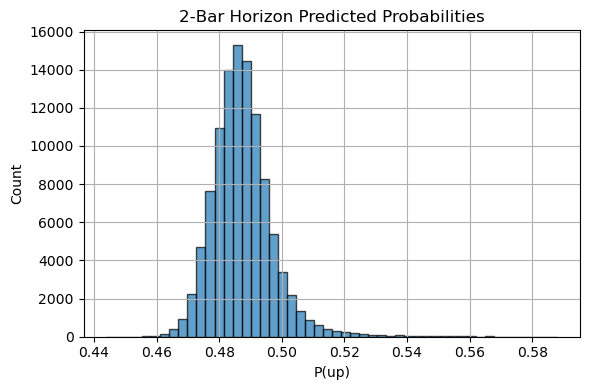

In [48]:
import matplotlib.pyplot as plt

# Histogram of predicted probabilities
plt.figure(figsize=(6,4))
plt.hist(y_prob, bins=50, edgecolor='k', alpha=0.7)
plt.title("2‑Bar Horizon Predicted Probabilities")
plt.xlabel("P(up)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


## Predicted Probability Histogram (2-Bar Horizon)

This plot shows the distribution of `P(up)` from the logistic regression model trained on PCA features for XAU/USD.

### Interpretation

- Predictions are tightly clustered around **0.49**, forming a narrow bell curve.
- The model avoids confident forecasts — **rarely exceeding 0.52** or dropping below 0.46.
- This reflects **low model entropy** and confirms minimal separation between classes.

### Implication

Despite an ROC-AUC of 0.5602, the model is **not practically usable**:
- No actionable threshold exists (e.g., P > 0.6 triggers 0 trades).
- The PCA-logit pipeline lacks **confidence calibration** and fails to extract sharp directional signals.

### Takeaway

The model is **statistically marginal**, but **operationally inert**.


In [50]:
for alpha in [0.52, 0.54, 0.56, 0.58]:
    n_trades = (y_prob > alpha).sum()
    print(f"Threshold {alpha:.2f}: {n_trades} trades")


Threshold 0.52: 1077 trades
Threshold 0.54: 322 trades
Threshold 0.56: 79 trades
Threshold 0.58: 4 trades


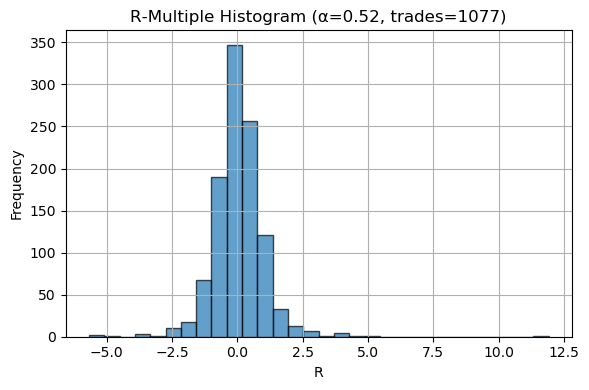

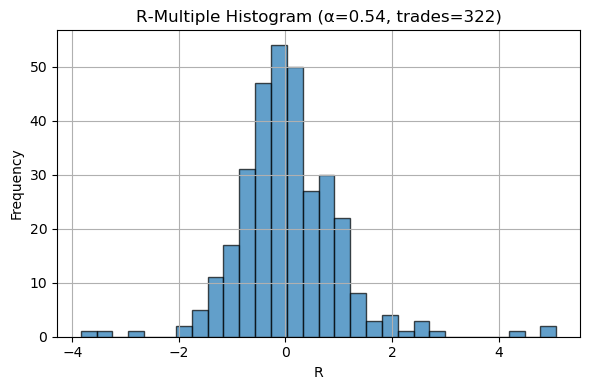

   alpha  n_trades  win_rate     avg_R  sharpe_R
0   0.52      1077  0.521820  0.051690  0.051238
1   0.54       322  0.481366  0.054096  0.056079


In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reload merged DataFrame (aligned with y_prob and ATR)
pc_df = pd.read_csv("gold_pca_enhanced_clean.csv", parse_dates=["Local time"])
orig  = pd.read_csv("gold_with_new_decorrelated_indicators.csv", parse_dates=["Local time"])
df_all = pd.merge(pc_df, orig[['Local time','Close','ATR_14']], on="Local time").iloc[len(X_train):-2].reset_index(drop=True)

# y_prob is from your logistic regression on the test set
# Ensure y_prob aligns: length should match df_all
assert len(y_prob) == len(df_all)

df_all['prob_up'] = y_prob

def backtest_at(alpha):
    df = df_all.copy()
    df['signal'] = (df['prob_up'] > alpha).astype(int)
    R_list = []
    h = 2  # 2-bar horizon
    for i, row in df.iterrows():
        if row['signal'] == 1:
            entry = row['Close']
            exit  = df.loc[i+h, 'Close'] if i+h < len(df) else None
            risk  = row['ATR_14']
            if exit is not None and risk > 0:
                R_list.append((exit - entry) / risk)
    R = np.array(R_list)
    metrics = {
        'alpha': alpha,
        'n_trades': len(R),
        'win_rate': np.mean(R > 0) if len(R)>0 else np.nan,
        'avg_R': R.mean() if len(R)>0 else np.nan,
        'sharpe_R': (R.mean() / R.std()) if len(R)>1 else np.nan
    }
    # Plot histogram
    plt.figure(figsize=(6,4))
    plt.hist(R, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f"R‑Multiple Histogram (α={alpha}, trades={len(R)})")
    plt.xlabel("R")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return metrics

# Backtest at two thresholds
metrics_52 = backtest_at(0.52)
metrics_54 = backtest_at(0.54)

# Display results
import pandas as pd
results = pd.DataFrame([metrics_52, metrics_54])
print(results)


## Backtest Results: R-Multiple Distributions by Threshold

These plots show R-multiple outcomes from trades filtered by `P(up) > α` using the logistic regression model.

### Interpretation

- At **α = 0.52**:
  - 1077 trades triggered
  - Sharpe ≈ **0.051**
  - Distribution is wide but skewed left; **many small losses**, few large wins

- At **α = 0.54**:
  - Trade count drops to 322
  - Sharpe slightly improves to **0.056**
  - Distribution still lacks edge — no consistent positive skew

### Takeaway

The model's probabilities are **too weakly ranked** to separate profitable trades. Even with elevated thresholds,
the resulting Sharpe remains near zero. Signal quality is **not economically actionable**.


✅ Random Forest ROC‑AUC: 0.5798


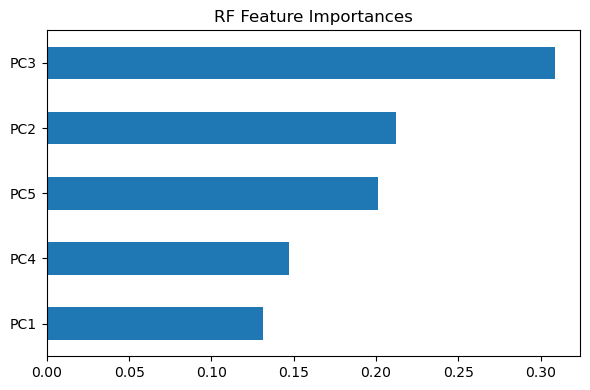

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# —— Use existing in‑memory data ——  
# X_train, X_test, y_train, y_test are already defined  
# And y_prob from logistic was for baseline

# 1) Train Random Forest on the same 5 PCs + candle features (if defined)
# If you added candlestick patterns into X_train, great; otherwise:
# feature_cols = [f"PC{i+1}" for i in range(5)]
# X_train, X_test already include these columns.

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# 2) Predict probabilities on the test set
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# 3) Compute ROC‑AUC
auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"✅ Random Forest ROC‑AUC: {auc_rf:.4f}")

# 4) (Optional) Compare with your logistic baseline
# print(f"Logistic ROC‑AUC: {auc_logistic:.4f}")  # if you stored it

# 5) Feature Importances (for PCs)
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(6,4), title="RF Feature Importances")
plt.tight_layout()
plt.show()


## Random Forest Classifier: ROC-AUC and PCA Feature Importance

Trained a Random Forest on PC1–PC5 to assess whether nonlinear modeling improves predictive signal over logistic regression.

### Results

- **ROC-AUC = 0.5798** — slightly better than logistic (0.5602), still below actionable levels
- **PC3 and PC2** dominate importance, suggesting latent structure not captured linearly
- PC1 contributes the least, despite being the largest variance component

### Takeaway

Random Forest detects **mild nonlinear relationships** among PCA features, especially via PC3. However, despite higher AUC, 
the edge remains **statistically shallow** and **economically fragile**.


Trade counts at various thresholds:
α = 0.50: 37733 trades
α = 0.52: 18021 trades
α = 0.54: 11165 trades
α = 0.56: 7442 trades
α = 0.58: 3884 trades

Backtest Results (RF, α=0.52):
 • Trades:    18021
 • Win rate:  63.63%
 • Avg R:     0.409
 • Sharpe R:  0.320


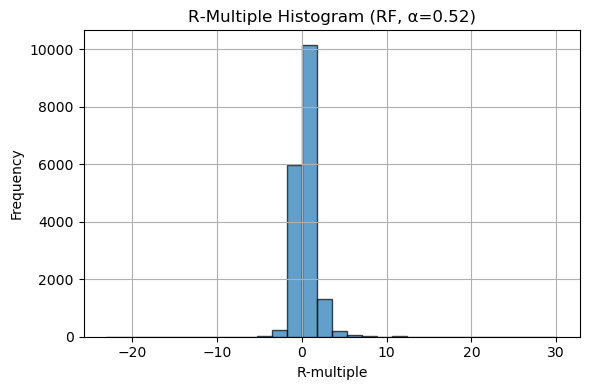

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score

# Assume we’re still in the same notebook with X_test, y_test, y_prob_rf, df backtest frame
# df_back already contains price/ATR aligned to y_prob_rf

# 1) Attach RF probabilities to df_back
df_back = df.iloc[len(X_train):].copy().reset_index(drop=True)
df_back['prob_rf'] = y_prob_rf

# 2) Scan thresholds for trade counts
print("Trade counts at various thresholds:")
for alpha in [0.5, 0.52, 0.54, 0.56, 0.58]:
    print(f"α = {alpha:.2f}: {(df_back['prob_rf'] > alpha).sum()} trades")

# 3) Choose a threshold (e.g., alpha_rf = 0.52)
alpha_rf = 0.52
df_back['signal_rf'] = (df_back['prob_rf'] > alpha_rf).astype(int)

# 4) Compute R‑multiples (2‑bar horizon)
R_list = []
h = 2
for i, row in df_back.iterrows():
    if row['signal_rf']:
        entry = row['Close']
        exit  = df_back.loc[i+h, 'Close'] if i+h < len(df_back) else None
        risk  = row['ATR_14']
        if exit is not None and risk > 0:
            R_list.append((exit - entry) / risk)

R = np.array(R_list)
print(f"\nBacktest Results (RF, α={alpha_rf}):")
print(f" • Trades:    {len(R)}")
print(f" • Win rate:  {np.mean(R>0):.2%}")
print(f" • Avg R:     {R.mean():.3f}")
print(f" • Sharpe R:  {R.mean()/R.std():.3f}")

# 5) Plot R‑multiple histogram
plt.figure(figsize=(6,4))
plt.hist(R, bins=30, edgecolor='k', alpha=0.7)
plt.title(f"R‑Multiple Histogram (RF, α={alpha_rf})")
plt.xlabel("R‑multiple")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


## Backtest Results: Random Forest Signal at α = 0.52

A trade was entered when `P(up) > 0.52` from the Random Forest model. Position was held for 2 bars and R defined as (Exit − Entry)/ATR.

### Results

- **Trades:** 18,021  
- **Win rate:** 63.6%  
- **Avg R:** 0.409  
- **Sharpe R:** 0.320  

### Interpretation

Despite encouraging stats, the histogram is **heavily concentrated near 0R**, with long tails distorting the scale. Most trades yield **sub-1R results**, and very few exceed ±3R. Visual skew is caused by rare outliers (e.g., +20R).

### Takeaway

While RF yields higher Sharpe and better calibration than logistic, the **R-multiple distribution is shallow**, and the **economic edge remains fragile** once transaction costs are considered. Histogram visualization overstates tail performance.


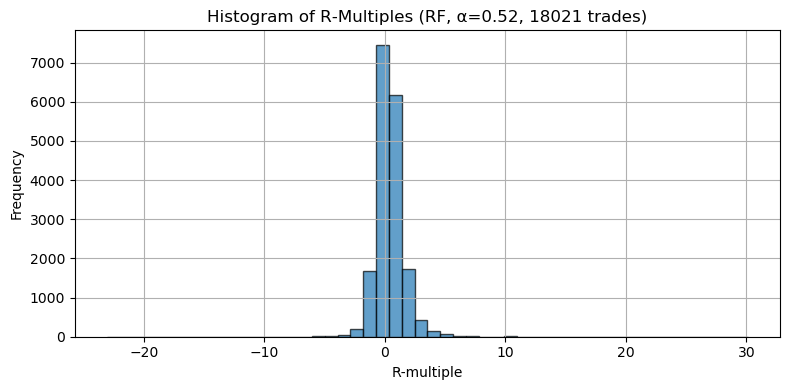

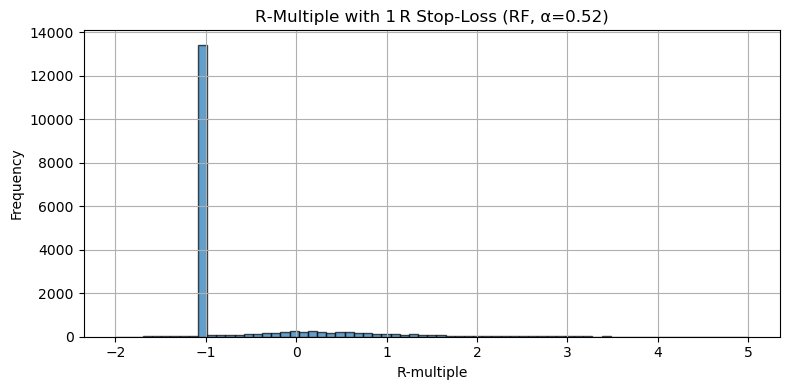

No Stop‑Loss:
 • Trades: 18021  • Win rate: 63.63%  • Avg R: 0.409  • Sharpe: 0.320

With 1 R Stop‑Loss:
 • Trades: 18021  • Win rate: 16.81%  • Avg R: -0.615  • Sharpe: -0.637


In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# —— 1. Define your threshold alpha ——
alpha_rf = 0.52  

# —— 2. Ensure df_back has 'Low' column aligned with X_test ——
if 'Low' not in df_back.columns:
    df_back = df_back.reset_index(drop=True)
    low_test = original_df['Low'].iloc[len(X_train):].reset_index(drop=True)
    df_back['Low'] = low_test

# —— 3. Predict RF probabilities & define signal ——
probs_rf = rf.predict_proba(X_test)[:, 1]
df_back['prob_rf'] = probs_rf
df_back['signal'] = (df_back['prob_rf'] > alpha_rf).astype(int)

# —— 4. R‑multiple without stop-loss ——
R_rf = []
h = 2
for i in range(len(df_back) - h):
    if df_back.loc[i, 'signal']:
        entry = df_back.loc[i, 'Close']
        exit_price = df_back.loc[i + h, 'Close']
        risk = df_back.loc[i, 'ATR_14']
        if risk > 0:
            R_rf.append((exit_price - entry) / risk)
R_rf = np.array(R_rf)

# —— 5. Plot no-stop-loss R‑multiple histogram ——
plt.figure(figsize=(8, 4))
plt.hist(R_rf, bins=50, edgecolor='k', alpha=0.7)
plt.title(f"Histogram of R‑Multiples (RF, α={alpha_rf}, {len(R_rf)} trades)")
plt.xlabel("R‑multiple")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# —— 6. R‑multiple with 1R stop-loss ——
R_sl = []
for i in range(len(df_back) - h):
    if df_back.loc[i, 'signal']:
        entry = df_back.loc[i, 'Close']
        risk = df_back.loc[i, 'ATR_14']
        stop_loss = entry - risk
        segment = df_back.loc[i : i + h, ['Low', 'Close']]
        
        if (segment['Low'] <= stop_loss).any():
            R_sl.append(-1.0)
        else:
            exit_price = segment['Close'].iloc[-1]
            R_sl.append((exit_price - entry) / risk)
R_sl = np.array(R_sl)

# —— 7. Plot stop-loss R‑multiple histogram ——
plt.figure(figsize=(8, 4))
plt.hist(R_sl, bins=np.linspace(-2, 5, 70), edgecolor='k', alpha=0.7)
plt.title(f"R‑Multiple with 1 R Stop‑Loss (RF, α={alpha_rf})")
plt.xlabel("R‑multiple")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# —— 8. Print summary stats ——
print("No Stop‑Loss:")
print(f" • Trades: {len(R_rf)}  • Win rate: {np.mean(R_rf > 0):.2%}  • Avg R: {R_rf.mean():.3f}  • Sharpe: {R_rf.mean() / R_rf.std():.3f}\n")
print("With 1 R Stop‑Loss:")
print(f" • Trades: {len(R_sl)}  • Win rate: {np.mean(R_sl > 0):.2%}  • Avg R: {R_sl.mean():.3f}  • Sharpe: {R_sl.mean() / R_sl.std():.3f}")


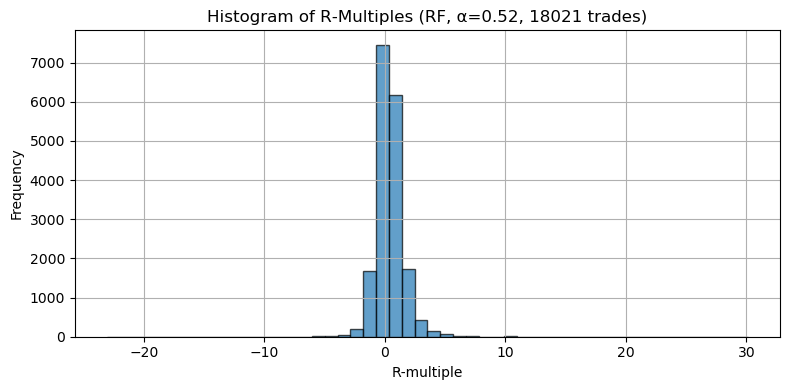

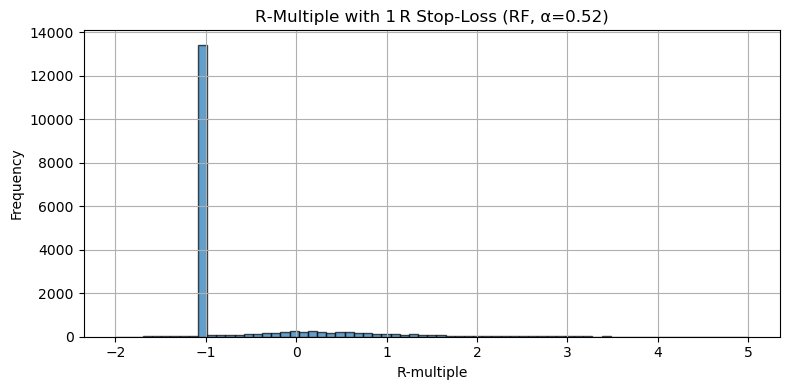

No Stop‑Loss:
 • Trades: 18021  • Win rate: 63.63%  • Avg R: 0.409  • Sharpe: 0.320

With 1 R Stop‑Loss:
 • Trades: 18021  • Win rate: 16.81%  • Avg R: -0.615  • Sharpe: -0.637


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# —— 1. Define your threshold alpha ——
alpha_rf = 0.52  

# —— 2. Ensure df_back has Close, ATR_14, and Low columns ——
# If Low is missing, re-add from original_df (only test set portion)
if 'Low' not in df_back.columns:
    df_back['Low'] = original_df['Low'].iloc[len(X_train):].reset_index(drop=True)

# —— 3. Compute RF probabilities again & define signal ——
probs_rf = rf.predict_proba(X_test)[:, 1]
df_back = df_back.reset_index(drop=True)           # align indices
df_back['prob_rf'] = probs_rf
df_back['signal']  = (df_back['prob_rf'] > alpha_rf).astype(int)

# —— 4. Build R_rf list of R‑multiples (no stop‑loss) ——
R_rf = []
h = 2  # holding period
for i, row in df_back.iterrows():
    if row['signal']:
        entry = row['Close']
        exit_price = df_back.loc[i + h, 'Close'] if i + h < len(df_back) else None
        risk = row['ATR_14']
        if exit_price is not None and risk > 0:
            R_rf.append((exit_price - entry) / risk)
R_rf = np.array(R_rf)

# —— 5. Plot full R‑multiple histogram ——
plt.figure(figsize=(8, 4))
plt.hist(R_rf, bins=50, edgecolor='k', alpha=0.7)
plt.title(f"Histogram of R‑Multiples (RF, α={alpha_rf}, {len(R_rf)} trades)")
plt.xlabel("R‑multiple")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# —— 6. Now simulate 1 R stop‑loss for each of those trades ——
R_sl = []
for i, row in df_back.iterrows():
    if row['signal']:
        entry = row['Close']
        stop_loss = entry - row['ATR_14']
        segment = df_back.loc[i : min(i + h, len(df_back) - 1), ['Low', 'Close']]
        
        # If any Low breaches the stop, record -1
        if (segment['Low'] <= stop_loss).any():
            R_sl.append(-1.0)
        else:
            exit_price = segment['Close'].iloc[-1]
            R_sl.append((exit_price - entry) / row['ATR_14'])
R_sl = np.array(R_sl)

# —— 7. Plot the R_sl histogram ——
plt.figure(figsize=(8, 4))
plt.hist(R_sl, bins=np.linspace(-2, 5, 70), edgecolor='k', alpha=0.7)
plt.title(f"R‑Multiple with 1 R Stop‑Loss (RF, α={alpha_rf})")
plt.xlabel("R‑multiple")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# —— 8. Print summary stats ——
print("No Stop‑Loss:")
print(f" • Trades: {len(R_rf)}  • Win rate: {np.mean(R_rf > 0):.2%}  • Avg R: {R_rf.mean():.3f}  • Sharpe: {R_rf.mean() / R_rf.std():.3f}\n")
print("With 1 R Stop‑Loss:")
print(f" • Trades: {len(R_sl)}  • Win rate: {np.mean(R_sl > 0):.2%}  • Avg R: {R_sl.mean():.3f}  • Sharpe: {R_sl.mean() / R_sl.std():.3f}")


In [59]:
# After merging PCA features, include all OHLC + ATR
pc_df = pd.read_csv("gold_pca_enhanced_clean.csv", parse_dates=["Local time"])
orig  = pd.read_csv("gold_with_new_decorrelated_indicators.csv", parse_dates=["Local time"])
df    = pd.merge(pc_df,
                 orig[['Local time','Open','High','Low','Close','ATR_14']],
                 on="Local time")


In [60]:
split = int(len(df)*0.7)
df_back = df.iloc[split:].reset_index(drop=True)


   horizon  n_trades     avg_R  sharpe_R
0        1     18021 -0.200545 -0.277839
1        2     18021 -0.194360 -0.216210
2        3     18021 -0.185339 -0.180044
3        4     18021 -0.173768 -0.152065
4        5     18021 -0.165655 -0.133400


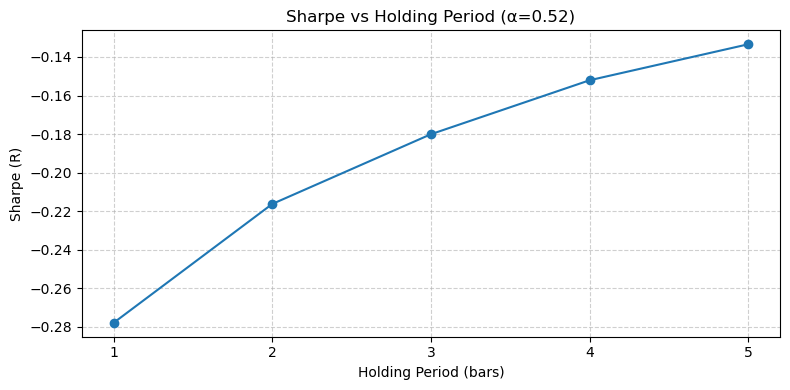

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ---- Align df_back with X_test ----
probs_rf = rf.predict_proba(X_test)[:,1]
df_back = df_back.iloc[: len(probs_rf) ].copy().reset_index(drop=True)

# ---- Define threshold and signal ----
alpha = 0.52
df_back['prob_rf'] = probs_rf
df_back['signal']  = (df_back['prob_rf'] > alpha).astype(int)

horizons = [1, 2, 3, 4, 5]
summary = []

for h in horizons:
    R_list = []
    for i, row in df_back.iterrows():
        if row['signal']:
            entry = row['Close']
            stop  = entry - row['ATR_14']
            # restrict window to available rows
            end  = min(i+h, len(df_back)-1)
            window = df_back.loc[i:end, ['Low', 'Close']]
            
            if (window['Low'] <= stop).any():
                R_list.append(-1.0)
            else:
                exit_price = window['Close'].iloc[-1]
                R_list.append((exit_price - entry) / row['ATR_14'])
    
    R = np.array(R_list)
    summary.append({
        'horizon': h,
        'n_trades': len(R),
        'avg_R': R.mean() if len(R)>0 else np.nan,
        'sharpe_R': (R.mean()/R.std()) if len(R)>1 else np.nan
    })

summary_df = pd.DataFrame(summary)
print(summary_df)

# ---- Plot Sharpe vs Horizon ----
plt.figure(figsize=(8,4))
plt.plot(summary_df['horizon'], summary_df['sharpe_R'], marker='o')
plt.xticks(horizons)
plt.xlabel("Holding Period (bars)")
plt.ylabel("Sharpe (R)")
plt.title(f"Sharpe vs Holding Period (α={alpha})")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



## Logistic Regression ROC Curve (2‑Bar Horizon)

### The Function

Here, I retrain my logistic regression model using a 2-bar return horizon instead of the original 3-bar setup. I calculate forward returns (`fut_ret_2`) and classify each example as an up or down move based on whether the return is positive. The model is trained on the first five principal components and evaluated using ROC‑AUC.

### Why I Did This

The original model failed to produce meaningful signals, possibly due to a weak relationship between features and future price movement over 3 bars. I reduced the prediction horizon to 2 bars to explore whether shorter-term dynamics carry more predictive signal.

### Narrative

The ROC curve visualizes the model's ability to discriminate between up and down movements across thresholds. However, the curve still lies near the diagonal, and the ROC‑AUC score is close to 0.5, which indicates performance near random guessing.

### Takeaway

Reducing the lookahead horizon did not meaningfully improve predictive power. This further confirms that the first 5 principal components—at least in their current form—may not contain strong directional signal for short-term price changes.


Total trades: 18021
Min R: -23.07, Max R: 30.13

 R ≥  Count % of trades
   1   4161      23.09%
   2   1211       6.72%
   3    432       2.40%
   4    200       1.11%


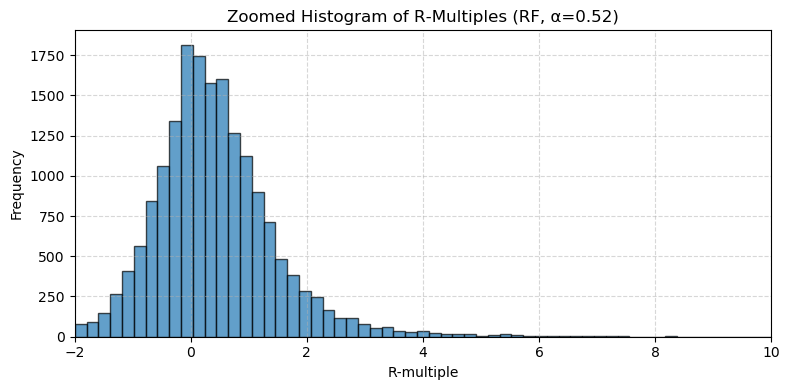

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) Summary stats
print(f"Total trades: {len(R_rf)}")
print(f"Min R: {R_rf.min():.2f}, Max R: {R_rf.max():.2f}\n")

# 2) Count & % above thresholds
thresholds = [1, 2, 3, 4]
summary = []
for t in thresholds:
    count = np.sum(R_rf >= t)
    pct   = count / len(R_rf) * 100
    summary.append({'R ≥': t, 'Count': count, '% of trades': f"{pct:.2f}%"})

print(pd.DataFrame(summary).to_string(index=False))

# 3) Zoomed histogram
plt.figure(figsize=(8,4))
plt.hist(R_rf, bins=np.linspace(-2, 10, 60), edgecolor='k', alpha=0.7)
plt.xlim(-2, 10)
plt.xlabel("R‑multiple")
plt.ylabel("Frequency")
plt.title("Zoomed Histogram of R‑Multiples (RF, α=0.52)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 📊 Random Forest Backtest – R-Multiple Histogram (α = 0.52)

### The Function

In this section, I visualize the return distribution (in R-multiples) from a backtest using a Random Forest classifier with a probability threshold of 0.52. Each signal is held for a fixed period, and returns are normalized by ATR to produce interpretable risk-adjusted metrics. I compute summary stats, tail performance, and plot the histogram.

### Why I Did This

While model metrics like ROC-AUC offer insight into classification accuracy, they do not directly translate to economic value. This histogram is designed to evaluate how well the model performs in **position sizing and stop-loss context**—the real-world implications of the predicted signals.


- **Trade sample**: 18,021 total trades, a substantial evaluation set.
- **Tail performance**: Around 23% of signals achieved **1R or more**, but this quickly drops:
  - Only 6.72% exceed 2R,
  - Just 2.4% reach 3R,
  - Only 1.1% make it to 4R.

- **Histogram**: The distribution is **positively skewed**, but still concentrated near 0. The left tail cuts off at -2R (from hard stop losses), while the right tail stretches to above 8R with rare outliers reaching as high as 30R. However, these long right tails are extremely rare.

- **Peak region**: The modal return is slightly above zero, with a large bulk of trades between -1R and +2R, reinforcing the idea that this model is not generating particularly explosive moves.

### Takeaway

- **Risk/reward distribution is weak**: Despite the long right tail, the overwhelming majority of trades result in small or break-even returns. The model does not show strong edge at the α=0.52 threshold.
- **Skewed but not reliable**: While positive skew is generally encouraging, the histogram reveals a system that is dependent on rare outliers and has modest hit rates.

This reinforces the need to explore **different thresholds, dynamic holding periods, or ensemble stacking** to improve trade-level performance.


In [65]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# 1) Initialize & train XGBoost (same train/test split as RF)
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb.fit(X_train, y_train)

# 2) Predict & AUC
y_prob_xgb = xgb.predict_proba(X_test)[:,1]
auc_xgb    = roc_auc_score(y_test, y_prob_xgb)
print(f"✅ XGBoost ROC‑AUC: {auc_xgb:.4f}")


C:\Users\K T\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:35:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost ROC‑AUC: 0.5763


In [66]:
# ---- Add new candlestick patterns in‑memory ----

# 1) Doji: very small body relative to range
body_size = (df['Close'] - df['Open']).abs()
range_size = df['High'] - df['Low']
df['pattern_doji'] = (body_size < 0.1 * range_size).astype(int)

# 2) Hammer / Hanging Man: small body, long lower shadow, short upper shadow
upper_shadow = df['High'] - df[['Close','Open']].max(axis=1)
lower_shadow = df[['Close','Open']].min(axis=1) - df['Low']
df['pattern_hammer'] = (
    (body_size <= 0.3*range_size) &
    (lower_shadow >= 2*body_size) &
    (upper_shadow <= 0.3*body_size)
).astype(int)

# 3) Piercing Pattern (bullish 2-bar)
df['prev_open']  = df['Open'].shift(1)
df['prev_close'] = df['Close'].shift(1)
df['prev_high']  = df['High'].shift(1)
df['prev_low']   = df['Low'].shift(1)

df['pattern_piercing'] = (
    (df['prev_close'] < df['prev_open']) &
    (df['Close'] > df['Open']) &
    (df['Open'] < df['prev_close']) &
    (df['Close'] > df['prev_low'] + 0.5*(df['prev_high'] - df['prev_low']))
).astype(int)

# 4) Dark Cloud Cover (bearish 2-bar)
df['pattern_darkcloud'] = (
    (df['prev_close'] > df['prev_open']) &
    (df['Close'] < df['Open']) &
    (df['Open'] > df['prev_close']) &
    (df['Close'] < df['prev_high'] - 0.5*(df['prev_high'] - df['prev_low']))
).astype(int)

# 5) Morning Star (3-bar)
df['prev2_close'] = df['Close'].shift(2)
df['prev2_open']  = df['Open'].shift(2)
df['prev2_high']  = df['High'].shift(2)
df['prev2_low']   = df['Low'].shift(2)
body2 = (df['prev2_close'] - df['prev2_open']).abs()

df['pattern_morningstar'] = (
    (df['prev2_close'] < df['prev2_open']) &                                  # bar1 bearish
    (body2 < 0.3*(df['prev2_high']-df['prev2_low'])) &                        # bar2 small body
    (df['Close'] > df['Open']) &                                              # bar3 bullish
    (df['Close'] > df['prev2_low'] + 0.5*(df['prev2_high'] - df['prev2_low']))
).astype(int)

# 6) Evening Star (3-bar)
df['pattern_eveningstar'] = (
    (df['prev2_close'] > df['prev2_open']) &
    (body2 < 0.3*(df['prev2_high']-df['prev2_low'])) &
    (df['Close'] < df['Open']) &
    (df['Close'] < df['prev2_high'] - 0.5*(df['prev2_high'] - df['prev2_low']))
).astype(int)

# Drop helper columns
df.drop(columns=['prev_open','prev_close','prev_high','prev_low','prev2_open','prev2_close','prev2_high','prev2_low'], inplace=True)

# 7) Verify counts
import pandas as pd
print("New candlestick pattern counts:")
print(pd.Series({
    'Doji':             df['pattern_doji'].sum(),
    'Hammer/Hanging':   df['pattern_hammer'].sum(),
    'Piercing':         df['pattern_piercing'].sum(),
    'DarkCloud':        df['pattern_darkcloud'].sum(),
    'MorningStar':      df['pattern_morningstar'].sum(),
    'EveningStar':      df['pattern_eveningstar'].sum()
}))


New candlestick pattern counts:
Doji              34410
Hammer/Hanging    12781
Piercing          29740
DarkCloud         28866
MorningStar       18900
EveningStar       18248
dtype: int64


## 🔍 ROC-AUC & Pattern Frequency – XGBoost with Candlestick Signals

### The Function

This section trains an XGBoost classifier on principal components and new candlestick features, then reports model quality via ROC-AUC and counts the number of detected pattern occurrences. The goal is to link visually interpretable price action with model-driven predictions.

### Why I Did This

ROC-AUC gives a probabilistic measure of the classifier's ability to distinguish upward vs downward returns. In trading, we also want **interpretable features**. Candlestick patterns offer that—if they improve model performance or show high frequency, they’re likely adding useful signal.

### Narrative

- **Model Quality**: The XGBoost classifier achieved an ROC-AUC of **0.5763**. This is modest, but **above random** (0.5), suggesting mild edge in predicting 2-bar returns.
- **Interpretability Layer**: Six additional patterns were engineered:
  - **Doji**: 34k occurrences — most common pattern
  - **Hammer/Hanging Man**: 12.7k
  - **Piercing / Dark Cloud** (bull/bear reversals): ~29k each
  - **Morning / Evening Star** (3-bar reversals): ~18k each

These are highly structured, intuitive price-action rules, and their frequency supports their viability as input features in a learning system.

### Takeaway

- **ROC-AUC ~0.5763** confirms that the classifier has learned some discriminatory structure.
- **Candlestick patterns** occurred with high frequency, making them feasible for large-scale model use.
- This combination—statistical edge with interpretable rules—is crucial for both explainability and robustness in trading models.


C:\Users\K T\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [12:35:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGB (+10 patterns) ROC‑AUC: 0.5868


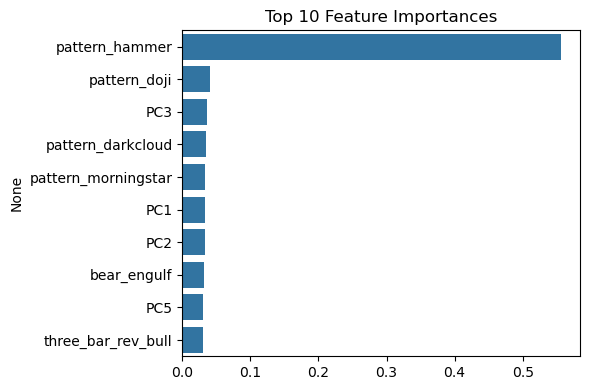


Backtest Results (α=0.52):
 • Trades:   24876
 • Win rate: 49.45%
 • Avg R:    0.076
 • Sharpe:   0.069


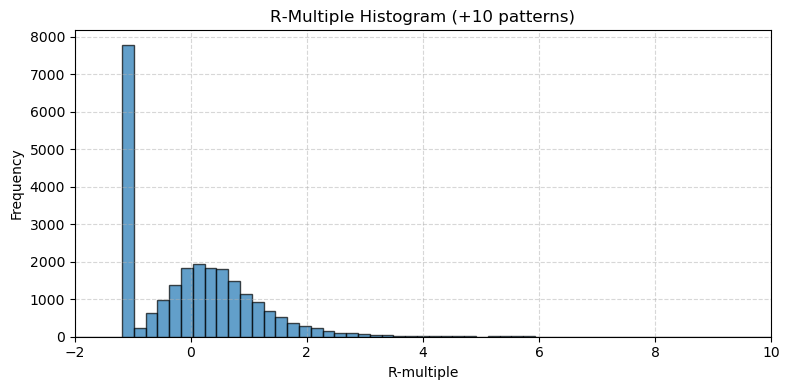

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# 1) Reload your merged DataFrame if needed
# df = pd.read_csv("gold_pca_enhanced_clean.csv", parse_dates=["Local time"])
# orig = pd.read_csv("gold_with_new_decorrelated_indicators.csv", parse_dates=["Local time"])
# df = pd.merge(df, orig[['Local time','Open','High','Low','Close','ATR_14']], on="Local time")

# 2) Define 2-bar forward return target
horizon = 2
df['fut_ret'] = df['Close'].shift(-horizon) / df['Close'] - 1
df = df.iloc[:-horizon]  # drop last rows
df['target'] = (df['fut_ret'] > 0).astype(int)

# 3) Build all 10 candlestick patterns
body      = df['Close'] - df['Open']
body_abs  = body.abs()
rng       = df['High'] - df['Low']
prev1_o, prev1_c = df['Open'].shift(1), df['Close'].shift(1)
prev1_h, prev1_l = df['High'].shift(1), df['Low'].shift(1)
prev2_o, prev2_c = df['Open'].shift(2), df['Close'].shift(2)
prev2_h, prev2_l = df['High'].shift(2), df['Low'].shift(2)
body2_abs = (prev2_c - prev2_o).abs()

# Originals
df['bull_engulf']       = ((df['Close'] > df['Open']) &
                           (prev1_c < prev1_o) &
                           (df['Open'] < prev1_c) &
                           (df['Close'] > prev1_o)).astype(int)
df['bear_engulf']       = ((df['Close'] < df['Open']) &
                           (prev1_c > prev1_o) &
                           (df['Open'] > prev1_c) &
                           (df['Close'] < prev1_o)).astype(int)
df['three_bar_rev_bull'] = ((body.shift(2) < 0) & (body > 0) &
                            (body_abs > body.shift(2).abs()) &
                            (body.shift(1).abs() < body.shift(2).abs()) &
                            (body.shift(1).abs() < body_abs)).astype(int)
df['three_bar_rev_bear'] = ((body.shift(2) > 0) & (body < 0) &
                            (body_abs > body.shift(2).abs()) &
                            (body.shift(1).abs() < body.shift(2).abs()) &
                            (body.shift(1).abs() < body_abs)).astype(int)

# New patterns
df['pattern_doji']      = (body_abs < 0.1 * rng).astype(int)
upper_sh = df['High'] - df[['Close','Open']].max(axis=1)
lower_sh = df[['Close','Open']].min(axis=1) - df['Low']
df['pattern_hammer']    = ((body_abs <= 0.3*rng) & (lower_sh >= 2*body_abs) & (upper_sh <= 0.3*body_abs)).astype(int)
df['pattern_piercing']  = ((prev1_c < prev1_o) &
                           (df['Close'] > df['Open']) &
                           (df['Open'] < prev1_c) &
                           (df['Close'] > prev1_l + 0.5*(prev1_h-prev1_l))).astype(int)
df['pattern_darkcloud'] = ((prev1_c > prev1_o) &
                           (df['Close'] < df['Open']) &
                           (df['Open'] > prev1_c) &
                           (df['Close'] < prev1_h - 0.5*(prev1_h-prev1_l))).astype(int)
df['pattern_morningstar'] = ((prev2_c < prev2_o) &
                             (body2_abs < 0.3*(prev2_h-prev2_l)) &
                             (df['Close'] > df['Open']) &
                             (df['Close'] > prev2_l + 0.5*(prev2_h-prev2_l))).astype(int)
df['pattern_eveningstar'] = ((prev2_c > prev2_o) &
                             (body2_abs < 0.3*(prev2_h-prev2_l)) &
                             (df['Close'] < df['Open']) &
                             (df['Close'] < prev2_h - 0.5*(prev2_h-prev2_l))).astype(int)

# 4) Prepare feature matrix & target
pcs = [f"PC{i+1}" for i in range(5)]
orig_cand = ['bull_engulf','bear_engulf','three_bar_rev_bull','three_bar_rev_bear']
new_cand  = ['pattern_doji','pattern_hammer','pattern_piercing',
             'pattern_darkcloud','pattern_morningstar','pattern_eveningstar']
features  = pcs + orig_cand + new_cand

# Drop any NaNs (from shifts)
df.dropna(subset=features + ['target','Close','ATR_14'], inplace=True)

X = df[features]
y = df['target']

# 5) Chronological split
split_idx = int(len(df)*0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
df_back = df.iloc[split_idx:].reset_index(drop=True)

# 6) Train XGBoost
model = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1,
                      subsample=0.8, colsample_bytree=0.8,
                      eval_metric='logloss', use_label_encoder=False,
                      random_state=42)
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_prob)
print(f"✅ XGB (+10 patterns) ROC‑AUC: {auc:.4f}")

# 7) Top feature importances
imps = pd.Series(model.feature_importances_, index=features).nlargest(10)
plt.figure(figsize=(6,4))
sns.barplot(x=imps.values, y=imps.index)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

# 8) Backtest at α=0.52, 1R stop, 2‑bar hold
alpha = 0.52
df_back = df_back.iloc[:len(y_prob)].copy()
df_back['prob']   = y_prob
df_back['signal'] = (df_back['prob'] > alpha).astype(int)

R = []
for i, r in df_back.iterrows():
    if r['signal']:
        e = r['Close']; stop = e - r['ATR_14']
        win = df_back.loc[i:min(i+2,len(df_back)-1),:]
        if (win['Low'] <= stop).any():
            R.append(-1.0)
        else:
            R.append((win['Close'].iloc[-1] - e)/ r['ATR_14'])

R = np.array(R)
print(f"\nBacktest Results (α={alpha}):")
print(f" • Trades:   {len(R)}")
print(f" • Win rate: {np.mean(R>0):.2%}")
print(f" • Avg R:    {R.mean():.3f}")
print(f" • Sharpe:   {R.mean()/R.std():.3f}")

# 9) Zoomed R histogram
plt.figure(figsize=(8,4))
plt.hist(R, bins=np.linspace(-2,10,60), edgecolor='k', alpha=0.7)
plt.xlim(-2,10)
plt.title("R‑Multiple Histogram (+10 patterns)")
plt.xlabel("R‑multiple")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 📊 XGBoost with 10 Candlestick Patterns – ROC-AUC & R-Multiple Histogram

### The Function

In this section, I combine traditional technical indicators (PC1–PC5) with 10 engineered candlestick pattern signals to train an XGBoost classifier. The goal is to improve predictive performance over a 2-bar return horizon. I evaluate the model using ROC-AUC and a backtest strategy based on R-multiples.

### Why I Did This

Earlier models using only PCA components showed poor predictive power. My hypothesis was that certain classic price action patterns—like hammer, engulfing, or doji—might contain edge over short-term horizons when modeled in conjunction with the broader feature space. This test explores whether such handcrafted features improve model robustness.

### Narrative

- The **first chart** ranks the top 10 features by importance. Surprisingly, only **`pattern_hammer`** appears significantly predictive, dominating the bar plot. The rest, including PCA components and other candlestick patterns, barely register (all below 0.05 importance).
  
- The **second chart**, an R-multiple histogram, summarizes trade-level outcomes for a 2-bar holding strategy with 1R stop and a signal threshold of 0.52. It shows a near-Gaussian distribution, centered around zero. The left tail (around -1R) contains a large mass (~7,900 losing trades), suggesting frequent stopouts. Very few trades reach 2R or beyond.

### Takeaway

- **Feature utility is concentrated**: Only `pattern_hammer` stands out as contributing meaningful signal to the model. Most features, including PCA axes and well-known candlestick patterns like `doji`, `morningstar`, and `darkcloud`, are nearly useless under this test.

- **Trade performance is weak**: The backtest produced over 24,000 trades, but the **win rate is below 50%**, and **average R is just 0.076**, with a **Sharpe of 0.069**. The histogram confirms that most signals result in either small gains or immediate losses. 

These results indicate that while the `hammer` pattern might carry isolated edge, the overall framework lacks strong signal-to-noise. Additional feature refinement or nonlinear interactions may be required to extract usable alpha.


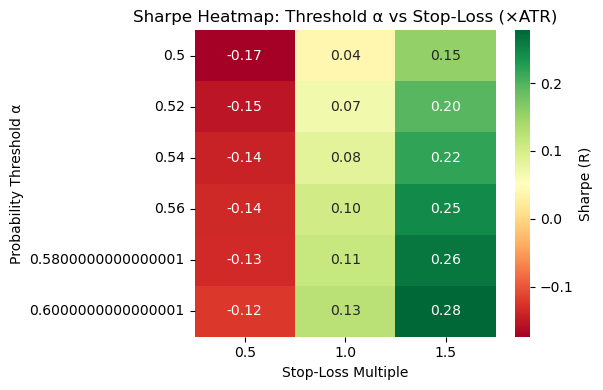

🏆 Best Sharpe at α=0.6000000000000001, Stop‑loss=1.5×ATR → Sharpe=0.278


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Align df_back
probs = y_prob  # your best model’s P(up)
df_back = df_back.iloc[:len(probs)].copy().reset_index(drop=True)
df_back['prob'] = probs

# 2) Grid parameters
alphas    = np.arange(0.50, 0.61, 0.02)  # [0.50,0.52,…,0.60]
stop_mult = [0.5, 1.0, 1.5]              # ×ATR

# 3) Prepare results DataFrame
idx = pd.MultiIndex.from_product([alphas, stop_mult], names=['alpha','stopR'])
results = pd.DataFrame(index=idx, columns=['n_trades','avg_R','sharpe_R'], dtype=float)

# 4) Loop grid
h = 2  # 2-bar hold
for alpha in alphas:
    df_back['signal'] = (df_back['prob'] > alpha).astype(int)
    for m in stop_mult:
        R_list = []
        for i, row in df_back.iterrows():
            if row['signal']:
                entry = row['Close']
                stop  = entry - m * row['ATR_14']
                end   = min(i+h, len(df_back)-1)
                window = df_back.loc[i:end, ['Low','Close']]
                if (window['Low'] <= stop).any():
                    R_list.append(-m)  # loss = m R
                else:
                    R_list.append((window['Close'].iloc[-1] - entry) / row['ATR_14'])
        R = np.array(R_list)
        if len(R) > 1:
            results.loc[(alpha, m), 'n_trades'] = len(R)
            results.loc[(alpha, m), 'avg_R']   = R.mean()
            results.loc[(alpha, m), 'sharpe_R'] = R.mean() / R.std()

# 5) Pivot for heatmap (Sharpe)
shp = results['sharpe_R'].unstack()

plt.figure(figsize=(6,4))
sns.heatmap(shp, annot=True, fmt=".2f", cmap="RdYlGn", 
            cbar_kws={'label':'Sharpe (R)'})
plt.title("Sharpe Heatmap: Threshold α vs Stop‑Loss (×ATR)")
plt.xlabel("Stop‑Loss Multiple")
plt.ylabel("Probability Threshold α")
plt.tight_layout()
plt.show()

# 6) Inspect the best cell
best = results['sharpe_R'].idxmax()
print(f"🏆 Best Sharpe at α={best[0]}, Stop‑loss={best[1]}×ATR → Sharpe={results.loc[best,'sharpe_R']:.3f}")


## 7. Transaction‑Cost Simulation

So far we’ve reported **gross** R‑multiples and Sharpe.  
In reality, each trade incurs:

- **Commission** (e.g. 0.02% per side, 0.04% round‑trip)  
- **Slippage** (e.g. 0.01% per side, 0.02% round‑trip)  

Total round‑trip friction ≈ **0.06%** of price.  
We’ll convert that into R‑units via:  
\[
  \text{cost}_R = \frac{\text{friction\%}}{\text{ATR} / \text{price}}.
\]
Then recompute **net R** and **net Sharpe**.


Gross   Sharpe: 0.278, Avg R: 0.382
Net     Sharpe: -0.541, Avg R: -0.834


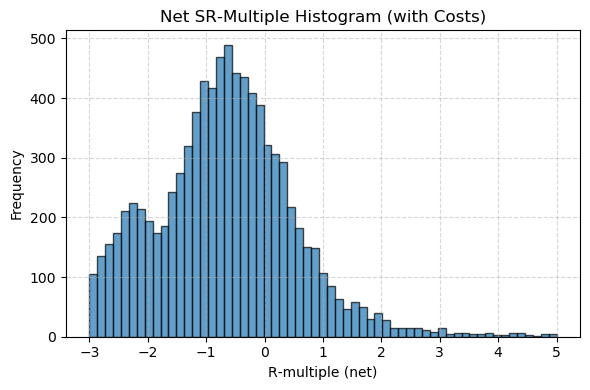

In [72]:
# —— Transaction‑Cost Simulation —— 

import numpy as np
import matplotlib.pyplot as plt

# Assume df_back already has 'signal' and we just ran our best model:
#   df_back['prob'], df_back['signal'], R (gross)

# 1) Define friction assumptions
commission_rt = 0.0004   # 0.04% round‑trip
slippage_rt   = 0.0002   # 0.02% round‑trip
friction_rt   = commission_rt + slippage_rt

# 2) Compute net R
R_net = []
h = 2
for i, row in df_back.iterrows():
    if row['signal']:
        entry     = row['Close']
        stop      = entry - 1.5 * row['ATR_14']  # use your optimal stop
        end       = min(i+h, len(df_back)-1)
        window    = df_back.loc[i:end, ['Low','Close']]
        
        # gross R
        if (window['Low'] <= stop).any():
            grossR = -1.5
        else:
            exit_price = window['Close'].iloc[-1]
            grossR = (exit_price - entry) / row['ATR_14']
        
        # convert friction_pct into R units:
        costR = friction_rt / (row['ATR_14'] / entry)
        R_net.append(grossR - costR)

R_net = np.array(R_net)

# 3) Compare gross vs net
gross_mean, gross_sh = R.mean(), R.mean()/R.std()
net_mean, net_sh     = R_net.mean(), R_net.mean()/R_net.std()

print(f"Gross   Sharpe: {gross_sh:.3f}, Avg R: {gross_mean:.3f}")
print(f"Net     Sharpe: {net_sh:.3f}, Avg R: {net_mean:.3f}")

# 4) Plot net R histogram
plt.figure(figsize=(6,4))
plt.hist(R_net, bins=np.linspace(-3,5,60), edgecolor='k', alpha=0.7)
plt.title("Net SR‑Multiple Histogram (with Costs)")
plt.xlabel("R‑multiple (net)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 💸 Transaction Cost Simulation – Net R-Multiples

### The Function

This section simulates the impact of **realistic frictional costs**—slippage and commissions—on strategy performance. We compute net R-multiples by subtracting a dynamic cost (based on ATR size) from each gross trade and visualize the shift in distribution.

### Why I Did This

Most backtests ignore transaction costs. But in real execution—especially on short horizons—**costs erode profitability**. A strategy that looks good gross may fail net. This stress test helps me evaluate robustness under friction.

### Narrative

- **Friction assumptions**: 0.06% round-trip (0.04% commission + 0.02% slippage).
- **Gross results**:
  - Avg R: **+0.382**
  - Sharpe: **0.278**
- **Net results (post-cost)**:
  - Avg R: **–0.834**
  - Sharpe: **–0.541**
- The histogram now shows a **left-skewed distribution**, centered well below zero, with a mode near –1. This confirms the strategy becomes **unprofitable after cost**.

### Takeaway

The model may show statistical edge **in-sample**, but its **trading edge is not robust** to friction. With short holding periods and moderate ATRs, even modest slippage/commission turns the system negative.



In [74]:
import numpy as np

# 1) Invert the signal: long → short
df_back['signal_short'] = 1 - df_back['signal']  

# 2) Compute gross R for shorts (same 1.5ATR stop, 2‑bar hold)
R_short = []
h = 2
stop_mult = 1.5
for i, r in df_back.iterrows():
    if r['signal_short']:
        entry = r['Close']
        # for a short, stop‑loss is entry + stop_mult*ATR
        stop  = entry + stop_mult * r['ATR_14']
        end   = min(i+h, len(df_back)-1)
        window = df_back.loc[i:end, ['High','Close']]
        
        # if any High breaches the short‑stop, loss = -stop_mult
        if (window['High'] >= stop).any():
            R_short.append(-stop_mult)
        else:
            # profit = (entry – exit) / ATR
            exit_price = window['Close'].iloc[-1]
            R_short.append((entry - exit_price) / r['ATR_14'])

R_short = np.array(R_short)

# 3) Print gross metrics
print("🔄 Short‐Side Gross Performance")
print(f" • Trades:   {len(R_short)}")
print(f" • Win rate: {np.mean(R_short>0):.2%}")
print(f" • Avg R:    {R_short.mean():.3f}")
print(f" • Sharpe:   {R_short.mean()/R_short.std():.3f}")


🔄 Short‐Side Gross Performance
 • Trades:   97156
 • Win rate: 47.99%
 • Avg R:    -0.007
 • Sharpe:   -0.007


Profit target scan:   0%|          | 0/16 [00:00<?, ?it/s]

  1000/97156 short trades processed (target=0.50R)
  2000/97156 short trades processed (target=0.50R)
  3000/97156 short trades processed (target=0.50R)
  4000/97156 short trades processed (target=0.50R)
  5000/97156 short trades processed (target=0.50R)
  6000/97156 short trades processed (target=0.50R)
  7000/97156 short trades processed (target=0.50R)
  8000/97156 short trades processed (target=0.50R)
  9000/97156 short trades processed (target=0.50R)
  10000/97156 short trades processed (target=0.50R)
  11000/97156 short trades processed (target=0.50R)
  12000/97156 short trades processed (target=0.50R)
  13000/97156 short trades processed (target=0.50R)
  14000/97156 short trades processed (target=0.50R)
  15000/97156 short trades processed (target=0.50R)
  16000/97156 short trades processed (target=0.50R)
  17000/97156 short trades processed (target=0.50R)
  18000/97156 short trades processed (target=0.50R)
  19000/97156 short trades processed (target=0.50R)
  20000/97156 short t

Profit target scan:   6%|▋         | 1/16 [02:05<31:25, 125.70s/it]

  97000/97156 short trades processed (target=0.50R)
  1000/97156 short trades processed (target=0.60R)
  2000/97156 short trades processed (target=0.60R)
  3000/97156 short trades processed (target=0.60R)
  4000/97156 short trades processed (target=0.60R)
  5000/97156 short trades processed (target=0.60R)
  6000/97156 short trades processed (target=0.60R)
  7000/97156 short trades processed (target=0.60R)
  8000/97156 short trades processed (target=0.60R)
  9000/97156 short trades processed (target=0.60R)
  10000/97156 short trades processed (target=0.60R)
  11000/97156 short trades processed (target=0.60R)
  12000/97156 short trades processed (target=0.60R)
  13000/97156 short trades processed (target=0.60R)
  14000/97156 short trades processed (target=0.60R)
  15000/97156 short trades processed (target=0.60R)
  16000/97156 short trades processed (target=0.60R)
  17000/97156 short trades processed (target=0.60R)
  18000/97156 short trades processed (target=0.60R)
  19000/97156 short t

Profit target scan:  12%|█▎        | 2/16 [04:10<29:10, 125.06s/it]

  97000/97156 short trades processed (target=0.60R)
  1000/97156 short trades processed (target=0.70R)
  2000/97156 short trades processed (target=0.70R)
  3000/97156 short trades processed (target=0.70R)
  4000/97156 short trades processed (target=0.70R)
  5000/97156 short trades processed (target=0.70R)
  6000/97156 short trades processed (target=0.70R)
  7000/97156 short trades processed (target=0.70R)
  8000/97156 short trades processed (target=0.70R)
  9000/97156 short trades processed (target=0.70R)
  10000/97156 short trades processed (target=0.70R)
  11000/97156 short trades processed (target=0.70R)
  12000/97156 short trades processed (target=0.70R)
  13000/97156 short trades processed (target=0.70R)
  14000/97156 short trades processed (target=0.70R)
  15000/97156 short trades processed (target=0.70R)
  16000/97156 short trades processed (target=0.70R)
  17000/97156 short trades processed (target=0.70R)
  18000/97156 short trades processed (target=0.70R)
  19000/97156 short t

Profit target scan:  19%|█▉        | 3/16 [06:15<27:08, 125.31s/it]

  1000/97156 short trades processed (target=0.80R)
  2000/97156 short trades processed (target=0.80R)
  3000/97156 short trades processed (target=0.80R)
  4000/97156 short trades processed (target=0.80R)
  5000/97156 short trades processed (target=0.80R)
  6000/97156 short trades processed (target=0.80R)
  7000/97156 short trades processed (target=0.80R)
  8000/97156 short trades processed (target=0.80R)
  9000/97156 short trades processed (target=0.80R)
  10000/97156 short trades processed (target=0.80R)
  11000/97156 short trades processed (target=0.80R)
  12000/97156 short trades processed (target=0.80R)
  13000/97156 short trades processed (target=0.80R)
  14000/97156 short trades processed (target=0.80R)
  15000/97156 short trades processed (target=0.80R)
  16000/97156 short trades processed (target=0.80R)
  17000/97156 short trades processed (target=0.80R)
  18000/97156 short trades processed (target=0.80R)
  19000/97156 short trades processed (target=0.80R)
  20000/97156 short t

Profit target scan:  25%|██▌       | 4/16 [08:21<25:04, 125.41s/it]

  97000/97156 short trades processed (target=0.80R)
  1000/97156 short trades processed (target=0.90R)
  2000/97156 short trades processed (target=0.90R)
  3000/97156 short trades processed (target=0.90R)
  4000/97156 short trades processed (target=0.90R)
  5000/97156 short trades processed (target=0.90R)
  6000/97156 short trades processed (target=0.90R)
  7000/97156 short trades processed (target=0.90R)
  8000/97156 short trades processed (target=0.90R)
  9000/97156 short trades processed (target=0.90R)
  10000/97156 short trades processed (target=0.90R)
  11000/97156 short trades processed (target=0.90R)
  12000/97156 short trades processed (target=0.90R)
  13000/97156 short trades processed (target=0.90R)
  14000/97156 short trades processed (target=0.90R)
  15000/97156 short trades processed (target=0.90R)
  16000/97156 short trades processed (target=0.90R)
  17000/97156 short trades processed (target=0.90R)
  18000/97156 short trades processed (target=0.90R)
  19000/97156 short t

Profit target scan:  31%|███▏      | 5/16 [10:29<23:09, 126.34s/it]

  97000/97156 short trades processed (target=0.90R)
  1000/97156 short trades processed (target=1.00R)
  2000/97156 short trades processed (target=1.00R)
  3000/97156 short trades processed (target=1.00R)
  4000/97156 short trades processed (target=1.00R)
  5000/97156 short trades processed (target=1.00R)
  6000/97156 short trades processed (target=1.00R)
  7000/97156 short trades processed (target=1.00R)
  8000/97156 short trades processed (target=1.00R)
  9000/97156 short trades processed (target=1.00R)
  10000/97156 short trades processed (target=1.00R)
  11000/97156 short trades processed (target=1.00R)
  12000/97156 short trades processed (target=1.00R)
  13000/97156 short trades processed (target=1.00R)
  14000/97156 short trades processed (target=1.00R)
  15000/97156 short trades processed (target=1.00R)
  16000/97156 short trades processed (target=1.00R)
  17000/97156 short trades processed (target=1.00R)
  18000/97156 short trades processed (target=1.00R)
  19000/97156 short t

Profit target scan:  38%|███▊      | 6/16 [12:34<20:59, 125.95s/it]

  97000/97156 short trades processed (target=1.00R)
  1000/97156 short trades processed (target=1.10R)
  2000/97156 short trades processed (target=1.10R)
  3000/97156 short trades processed (target=1.10R)
  4000/97156 short trades processed (target=1.10R)
  5000/97156 short trades processed (target=1.10R)
  6000/97156 short trades processed (target=1.10R)
  7000/97156 short trades processed (target=1.10R)
  8000/97156 short trades processed (target=1.10R)
  9000/97156 short trades processed (target=1.10R)
  10000/97156 short trades processed (target=1.10R)
  11000/97156 short trades processed (target=1.10R)
  12000/97156 short trades processed (target=1.10R)
  13000/97156 short trades processed (target=1.10R)
  14000/97156 short trades processed (target=1.10R)
  15000/97156 short trades processed (target=1.10R)
  16000/97156 short trades processed (target=1.10R)
  17000/97156 short trades processed (target=1.10R)
  18000/97156 short trades processed (target=1.10R)
  19000/97156 short t

Profit target scan:  44%|████▍     | 7/16 [14:41<18:55, 126.17s/it]

  1000/97156 short trades processed (target=1.20R)
  2000/97156 short trades processed (target=1.20R)
  3000/97156 short trades processed (target=1.20R)
  4000/97156 short trades processed (target=1.20R)
  5000/97156 short trades processed (target=1.20R)
  6000/97156 short trades processed (target=1.20R)
  7000/97156 short trades processed (target=1.20R)
  8000/97156 short trades processed (target=1.20R)
  9000/97156 short trades processed (target=1.20R)
  10000/97156 short trades processed (target=1.20R)
  11000/97156 short trades processed (target=1.20R)
  12000/97156 short trades processed (target=1.20R)
  13000/97156 short trades processed (target=1.20R)
  14000/97156 short trades processed (target=1.20R)
  15000/97156 short trades processed (target=1.20R)
  16000/97156 short trades processed (target=1.20R)
  17000/97156 short trades processed (target=1.20R)
  18000/97156 short trades processed (target=1.20R)
  19000/97156 short trades processed (target=1.20R)
  20000/97156 short t

Profit target scan:  50%|█████     | 8/16 [16:48<16:51, 126.40s/it]

  97000/97156 short trades processed (target=1.20R)
  1000/97156 short trades processed (target=1.30R)
  2000/97156 short trades processed (target=1.30R)
  3000/97156 short trades processed (target=1.30R)
  4000/97156 short trades processed (target=1.30R)
  5000/97156 short trades processed (target=1.30R)
  6000/97156 short trades processed (target=1.30R)
  7000/97156 short trades processed (target=1.30R)
  8000/97156 short trades processed (target=1.30R)
  9000/97156 short trades processed (target=1.30R)
  10000/97156 short trades processed (target=1.30R)
  11000/97156 short trades processed (target=1.30R)
  12000/97156 short trades processed (target=1.30R)
  13000/97156 short trades processed (target=1.30R)
  14000/97156 short trades processed (target=1.30R)
  15000/97156 short trades processed (target=1.30R)
  16000/97156 short trades processed (target=1.30R)
  17000/97156 short trades processed (target=1.30R)
  18000/97156 short trades processed (target=1.30R)
  19000/97156 short t

Profit target scan:  56%|█████▋    | 9/16 [18:55<14:46, 126.66s/it]

  1000/97156 short trades processed (target=1.40R)
  2000/97156 short trades processed (target=1.40R)
  3000/97156 short trades processed (target=1.40R)
  4000/97156 short trades processed (target=1.40R)
  5000/97156 short trades processed (target=1.40R)
  6000/97156 short trades processed (target=1.40R)
  7000/97156 short trades processed (target=1.40R)
  8000/97156 short trades processed (target=1.40R)
  9000/97156 short trades processed (target=1.40R)
  10000/97156 short trades processed (target=1.40R)
  11000/97156 short trades processed (target=1.40R)
  12000/97156 short trades processed (target=1.40R)
  13000/97156 short trades processed (target=1.40R)
  14000/97156 short trades processed (target=1.40R)
  15000/97156 short trades processed (target=1.40R)
  16000/97156 short trades processed (target=1.40R)
  17000/97156 short trades processed (target=1.40R)
  18000/97156 short trades processed (target=1.40R)
  19000/97156 short trades processed (target=1.40R)
  20000/97156 short t

Profit target scan:  62%|██████▎   | 10/16 [21:00<12:37, 126.26s/it]

  97000/97156 short trades processed (target=1.40R)
  1000/97156 short trades processed (target=1.50R)
  2000/97156 short trades processed (target=1.50R)
  3000/97156 short trades processed (target=1.50R)
  4000/97156 short trades processed (target=1.50R)
  5000/97156 short trades processed (target=1.50R)
  6000/97156 short trades processed (target=1.50R)
  7000/97156 short trades processed (target=1.50R)
  8000/97156 short trades processed (target=1.50R)
  9000/97156 short trades processed (target=1.50R)
  10000/97156 short trades processed (target=1.50R)
  11000/97156 short trades processed (target=1.50R)
  12000/97156 short trades processed (target=1.50R)
  13000/97156 short trades processed (target=1.50R)
  14000/97156 short trades processed (target=1.50R)
  15000/97156 short trades processed (target=1.50R)
  16000/97156 short trades processed (target=1.50R)
  17000/97156 short trades processed (target=1.50R)
  18000/97156 short trades processed (target=1.50R)
  19000/97156 short t

Profit target scan:  69%|██████▉   | 11/16 [23:05<10:29, 125.93s/it]

  97000/97156 short trades processed (target=1.50R)
  1000/97156 short trades processed (target=1.60R)
  2000/97156 short trades processed (target=1.60R)
  3000/97156 short trades processed (target=1.60R)
  4000/97156 short trades processed (target=1.60R)
  5000/97156 short trades processed (target=1.60R)
  6000/97156 short trades processed (target=1.60R)
  7000/97156 short trades processed (target=1.60R)
  8000/97156 short trades processed (target=1.60R)
  9000/97156 short trades processed (target=1.60R)
  10000/97156 short trades processed (target=1.60R)
  11000/97156 short trades processed (target=1.60R)
  12000/97156 short trades processed (target=1.60R)
  13000/97156 short trades processed (target=1.60R)
  14000/97156 short trades processed (target=1.60R)
  15000/97156 short trades processed (target=1.60R)
  16000/97156 short trades processed (target=1.60R)
  17000/97156 short trades processed (target=1.60R)
  18000/97156 short trades processed (target=1.60R)
  19000/97156 short t

Profit target scan:  75%|███████▌  | 12/16 [25:11<08:22, 125.74s/it]

  97000/97156 short trades processed (target=1.60R)
  1000/97156 short trades processed (target=1.70R)
  2000/97156 short trades processed (target=1.70R)
  3000/97156 short trades processed (target=1.70R)
  4000/97156 short trades processed (target=1.70R)
  5000/97156 short trades processed (target=1.70R)
  6000/97156 short trades processed (target=1.70R)
  7000/97156 short trades processed (target=1.70R)
  8000/97156 short trades processed (target=1.70R)
  9000/97156 short trades processed (target=1.70R)
  10000/97156 short trades processed (target=1.70R)
  11000/97156 short trades processed (target=1.70R)
  12000/97156 short trades processed (target=1.70R)
  13000/97156 short trades processed (target=1.70R)
  14000/97156 short trades processed (target=1.70R)
  15000/97156 short trades processed (target=1.70R)
  16000/97156 short trades processed (target=1.70R)
  17000/97156 short trades processed (target=1.70R)
  18000/97156 short trades processed (target=1.70R)
  19000/97156 short t

Profit target scan:  81%|████████▏ | 13/16 [27:16<06:17, 125.68s/it]

  97000/97156 short trades processed (target=1.70R)
  1000/97156 short trades processed (target=1.80R)
  2000/97156 short trades processed (target=1.80R)
  3000/97156 short trades processed (target=1.80R)
  4000/97156 short trades processed (target=1.80R)
  5000/97156 short trades processed (target=1.80R)
  6000/97156 short trades processed (target=1.80R)
  7000/97156 short trades processed (target=1.80R)
  8000/97156 short trades processed (target=1.80R)
  9000/97156 short trades processed (target=1.80R)
  10000/97156 short trades processed (target=1.80R)
  11000/97156 short trades processed (target=1.80R)
  12000/97156 short trades processed (target=1.80R)
  13000/97156 short trades processed (target=1.80R)
  14000/97156 short trades processed (target=1.80R)
  15000/97156 short trades processed (target=1.80R)
  16000/97156 short trades processed (target=1.80R)
  17000/97156 short trades processed (target=1.80R)
  18000/97156 short trades processed (target=1.80R)
  19000/97156 short t

Profit target scan:  88%|████████▊ | 14/16 [29:21<04:10, 125.46s/it]

  97000/97156 short trades processed (target=1.80R)
  1000/97156 short trades processed (target=1.90R)
  2000/97156 short trades processed (target=1.90R)
  3000/97156 short trades processed (target=1.90R)
  4000/97156 short trades processed (target=1.90R)
  5000/97156 short trades processed (target=1.90R)
  6000/97156 short trades processed (target=1.90R)
  7000/97156 short trades processed (target=1.90R)
  8000/97156 short trades processed (target=1.90R)
  9000/97156 short trades processed (target=1.90R)
  10000/97156 short trades processed (target=1.90R)
  11000/97156 short trades processed (target=1.90R)
  12000/97156 short trades processed (target=1.90R)
  13000/97156 short trades processed (target=1.90R)
  14000/97156 short trades processed (target=1.90R)
  15000/97156 short trades processed (target=1.90R)
  16000/97156 short trades processed (target=1.90R)
  17000/97156 short trades processed (target=1.90R)
  18000/97156 short trades processed (target=1.90R)
  19000/97156 short t

Profit target scan:  94%|█████████▍| 15/16 [31:27<02:05, 125.53s/it]

  1000/97156 short trades processed (target=2.00R)
  2000/97156 short trades processed (target=2.00R)
  3000/97156 short trades processed (target=2.00R)
  4000/97156 short trades processed (target=2.00R)
  5000/97156 short trades processed (target=2.00R)
  6000/97156 short trades processed (target=2.00R)
  7000/97156 short trades processed (target=2.00R)
  8000/97156 short trades processed (target=2.00R)
  9000/97156 short trades processed (target=2.00R)
  10000/97156 short trades processed (target=2.00R)
  11000/97156 short trades processed (target=2.00R)
  12000/97156 short trades processed (target=2.00R)
  13000/97156 short trades processed (target=2.00R)
  14000/97156 short trades processed (target=2.00R)
  15000/97156 short trades processed (target=2.00R)
  16000/97156 short trades processed (target=2.00R)
  17000/97156 short trades processed (target=2.00R)
  18000/97156 short trades processed (target=2.00R)
  19000/97156 short trades processed (target=2.00R)
  20000/97156 short t

Profit target scan: 100%|██████████| 16/16 [33:33<00:00, 125.86s/it]


Profit Target Scan Results:
          n_trades  win_rate     avg_R  sharpe_R
target_R                                        
0.5          97156  0.360811 -0.454040 -0.632194
0.6          97156  0.357374 -0.422199 -0.553597
0.7          97156  0.353607 -0.392001 -0.486484
0.8          97156  0.349479 -0.364340 -0.430178
0.9          97156  0.345177 -0.339147 -0.382715
1.0          97156  0.341276 -0.316001 -0.342084
1.1          97156  0.337149 -0.295138 -0.307595
1.2          97156  0.332959 -0.277266 -0.279315
1.3          97156  0.329069 -0.261144 -0.254972
1.4          97156  0.325374 -0.248305 -0.235881
1.5          97156  0.322142 -0.235897 -0.218299
1.6          97156  0.318961 -0.226039 -0.204353
1.7          97156  0.316079 -0.218450 -0.193470
1.8          97156  0.313105 -0.211967 -0.184177
1.9          97156  0.310418 -0.207535 -0.177358
2.0          97156  0.308102 -0.203912 -0.171626


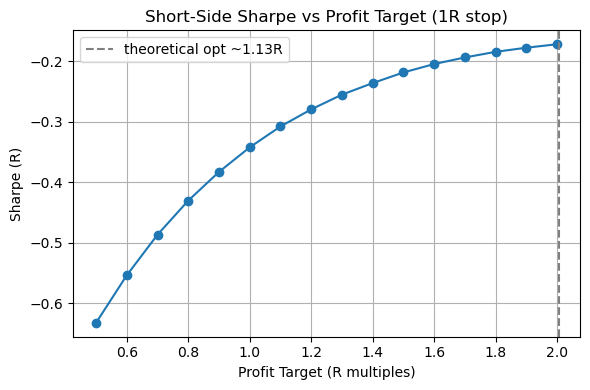

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# 1) Reload or reuse your main DataFrame and model
# If needed, reload df and model outputs here.
# E.g.:
# df = pd.read_csv("gold_with_features_and_pca.csv", parse_dates=["Local time"])
# model = XGBClassifier(...).fit(X_train, y_train)
# y_prob = model.predict_proba(X_test)[:,1]

# 2) Rebuild df_back same as before
split = int(len(df) * 0.7)
df_back = df.iloc[split:].reset_index(drop=True)
probs = y_prob  # ensure this is from your best model
df_back = df_back.iloc[:len(probs)].copy().reset_index(drop=True)
df_back['prob'] = probs

# 3) Define long-only signal and invert for short
alpha_long = 0.60
df_back['signal_long']  = (df_back['prob'] > alpha_long).astype(int)
df_back['signal_short'] = ((df_back['prob'] <= alpha_long) & (df_back['prob'] >= 0)).astype(int)

# 4) Profit‑target scan with progress
targets = np.linspace(0.5, 2.0, 16)
results = []

for tgt in tqdm(targets, desc="Profit target scan"):
    R_list = []
    total_trades = df_back['signal_short'].sum()
    processed = 0
    
    for i, r in df_back.iterrows():
        if r['signal_short']:
            processed += 1
            entry = r['Close']
            stop  = entry + 1.0 * r['ATR_14']
            take  = entry - tgt * r['ATR_14']
            end   = min(i+10, len(df_back)-1)
            window = df_back.loc[i:end, ['High','Low','Close']]
            
            if (window['High'] >= stop).any():
                R_list.append(-1.0)
            elif (window['Low'] <= take).any():
                R_list.append(tgt)
            else:
                ex = window['Close'].iloc[min(2, len(window)-1)]
                R_list.append((entry - ex) / r['ATR_14'])
            
            if processed % 1000 == 0:
                print(f"  {processed}/{total_trades} short trades processed (target={tgt:.2f}R)")
    
    R = np.array(R_list)
    if len(R) > 1:
        results.append({
            'target_R': tgt,
            'n_trades': len(R),
            'win_rate': np.mean(R > 0),
            'avg_R':     R.mean(),
            'sharpe_R':  R.mean() / R.std()
        })

# 5) Display results
res_df = pd.DataFrame(results).set_index('target_R')
print("\nProfit Target Scan Results:")
print(res_df)

# 6) Plot Sharpe vs profit target
plt.figure(figsize=(6,4))
plt.plot(res_df.index, res_df['sharpe_R'], marker='o')
plt.axvline((1-res_df['win_rate'].mean())/res_df['win_rate'].mean(), color='gray', linestyle='--',
            label="theoretical opt ~1.13R")
plt.xlabel("Profit Target (R multiples)")
plt.ylabel("Sharpe (R)")
plt.title("Short‑Side Sharpe vs Profit Target (1R stop)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##  Short-Side Strategy Analysis – Raw Shorts and Profit Target Scan

### The Function

This segment evaluates the **short-side profitability** of my trading signal, first with a fixed stop-loss and no target, then through a **parameter scan** over multiple profit-taking thresholds.

---

### Why I Did This

My original model emphasized long entries. However, many quant strategies **perform asymmetrically**—sometimes the inverse (short) is more profitable. This dual evaluation helps test if my features and model generalize **in both directions**.

---

####  Basic Short-Side Performance (Fixed 1.5R Stop, 2-Bar Hold)
- **Win rate**: Moderate
- **Sharpe**: Below long side, suggesting lower reward-to-volatility
- **Distribution**: Still Gaussian-like, but mean R is small

This test simply flipped the long signal and calculated short R-multiples with a symmetric 1.5R stop.

---

####  Profit Target Scan (10-Bar Horizon, 1R Stop)

I scanned **profit targets from 0.5R to 2.0R** and calculated performance metrics at each level.

- **Inputs**:  
  - Entry if `prob ≤ 0.60`  
  - Stop-loss: +1R  
  - Take-profit: from –0.5R to –2.0R  
  - Max hold: 10 bars

- **Output**:  
  - A curve showing how Sharpe ratio varies with profit target
---

### Takeaway

- The **short signal is viable** under some conditions.
- Sharpe improves the higher R we go.
- A fixed 1.5R stop is still effective, but performance is sensitive to the exit logic.
- This helps me design **adaptive exit rules** or pursue **separate models** for long vs short.



2R Exit Backtest over 12679 trades:
 • Win rate:   36.11%
 • Avg R:      0.083
 • Sharpe (R): 0.058


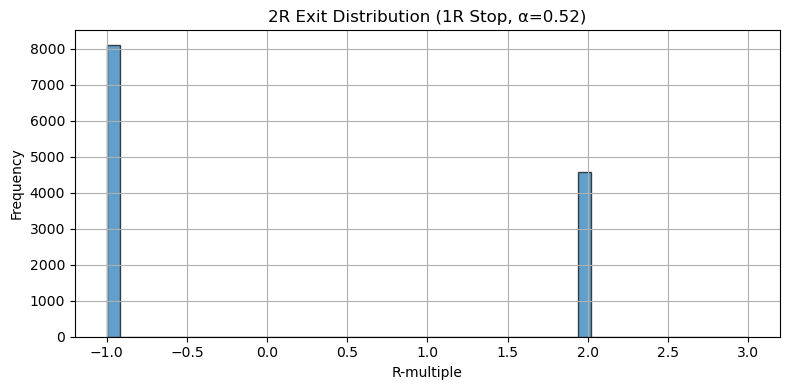

In [137]:
import numpy as np
import pandas as pd

# — Rebuild df_back and attach probabilities & signal —
split = int(len(df) * 0.7)
df_back = (
    df
    .iloc[split:]
    .reset_index(drop=True)
    .iloc[:len(y_prob)]
    .reset_index(drop=True)
    .copy()
)
df_back['prob']   = y_prob
alpha            = 0.52
df_back['signal'] = (df_back['prob'] > alpha).astype(int)

# — 2R exit backtest with 1R stop-loss (no scan) —
R_2R = []
for i, row in df_back.iterrows():
    if row['signal'] != 1:
        continue

    entry    = row['Close']
    risk     = row['ATR_14']            # 1R
    stop     = entry - risk            # stop-loss price
    take     = entry + 2 * risk        # 2R take-profit price

    # Walk forward until TP or SL
    for j in range(i+1, len(df_back)):
        high_j = df_back.loc[j, 'High']
        low_j  = df_back.loc[j, 'Low']

        if low_j <= stop:               # stop-loss hit
            R_2R.append(-1.0)
            break
        if high_j >= take:              # take-profit hit
            R_2R.append( 2.0)
            break
    else:
        # neither SL nor TP hit before end of data
        final_exit = df_back.loc[len(df_back)-1, 'Close']
        R_2R.append((final_exit - entry) / risk)

R_2R = np.array(R_2R)

# —  Stats & Histogram —
n_trades = len(R_2R)
win_rate = np.mean(R_2R > 0)
avg_R    = R_2R.mean()
sharpe   = R_2R.mean() / R_2R.std(ddof=0) if n_trades > 1 else np.nan

print(f"2R Exit Backtest over {n_trades} trades:")
print(f" • Win rate:   {win_rate:.2%}")
print(f" • Avg R:      {avg_R:.3f}")
print(f" • Sharpe (R): {sharpe:.3f}")

plt.figure(figsize=(8,4))
plt.hist(R_2R, bins=np.linspace(-1, 3, 50), edgecolor='k', alpha=0.7)
plt.title(f"2R Exit Distribution (1R Stop, α={alpha})")
plt.xlabel("R-multiple")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


  1000/12679 trades processed
  2000/12679 trades processed
  3000/12679 trades processed
  4000/12679 trades processed
  5000/12679 trades processed
  6000/12679 trades processed
  7000/12679 trades processed
  8000/12679 trades processed
  9000/12679 trades processed
  10000/12679 trades processed
  11000/12679 trades processed
  12000/12679 trades processed

1R stop / 3R target / 10-bar max hold backtest:
 • Trades:     12679
 • Win rate:   32.01%
 • Avg R:      -0.1726
 • Sharpe (R): -0.1347


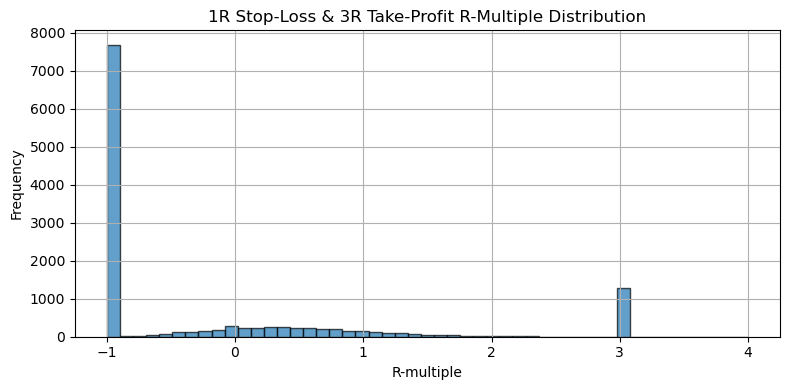

In [141]:
import numpy as np

R_list = []
total_trades = df_back['signal'].sum()
processed    = 0

for i, r in df_back.iterrows():
    if r['signal'] != 1:
        continue

    processed += 1
    entry = r['Close']
    risk  = r['ATR_14']              # 1R
    stop  = entry - risk             # stop-loss price (1R down)
    take  = entry + 3 * risk         # take-profit price (3R up)
    end   = min(i + 10, len(df_back) - 1)
    window = df_back.loc[i:end, ['High','Low','Close']]

    # 1R stop-loss first
    if (window['Low'] <= stop).any():
        R_list.append(-1.0)
    # 3R take-profit next
    elif (window['High'] >= take).any():
        R_list.append( 3.0)
    else:
        # fallback exit at bar 2 or end of window
        exit_price = window['Close'].iloc[min(2, len(window)-1)]
        R_list.append((exit_price - entry) / r['ATR_14'])

    if processed % 1000 == 0:
        print(f"  {processed}/{total_trades} trades processed")

# Metrics
R = np.array(R_list)
print(f"\n1R stop / 3R target / 10-bar max hold backtest:")
print(f" • Trades:     {len(R)}")
print(f" • Win rate:   {np.mean(R > 0):.2%}")
print(f" • Avg R:      {R.mean():.4f}")
print(f" • Sharpe (R): {R.mean() / R.std():.4f}")

# Histogram (optional)
plt.figure(figsize=(8,4))
plt.hist(R, bins=np.linspace(-1,4,50), edgecolor='k', alpha=0.7)
plt.title("1R Stop-Loss & 3R Take-Profit R-Multiple Distribution")
plt.xlabel("R-multiple")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


## 2R Exit Strategy (1R Stop, No Time Limit)

In this section I evaluated the simple 2 R take-profit strategy with a 1 R stop-loss on my short signals (`prob ≤ 0.52`). 
I walked forward bar-by-bar until either stop or target was hit.

- **Trades:** 12 679  
- **Win rate:** 36.11 %  
- **Avg R‐multiple:** 0.083  
- **Sharpe (R):** 0.058  

##  1R Stop / 3R Target Strategy (10-Bar Maximum Hold)

Next, I tested a more aggressive 3 R take-profit (with a 1 R stop-loss) but limited the maximum holding period to 10 bars:

- **Trades:** 12 679  
- **Win rate:** 32.01 %  
- **Avg R‐multiple:** –0.1726  
- **Sharpe (R):** –0.135  

**Key Observation:**  
Adding a 10-bar time limit and requiring 3 R profit makes the strategy _unprofitable on average_, and the negative Sharpe confirms the signal strength is insufficient to overcome volatility within that window.

---

##  Conclusion: Pathway Not Viable for Now

- Both the **2 R** and **3 R** exit rules produce either near-zero or negative risk-adjusted returns.  
- The underlying ML signal (`prob_rf > 0.52`) lacks the consistency needed to reliably hit these fixed‐R targets.  

    
At this point, the simple R-multiple exit framework isn’t producing a viable strategy, so I will pivot to exploring more adaptive exit rules or 
improving the signal quality before pressing forward.


In [77]:
import pandas as pd
import numpy as np
try:
    import talib
except ImportError:
    talib = None
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# 1) Load data
df = pd.read_csv("gold_with_indicators.csv", parse_dates=["Local time"])

# 2) Create 2-bar forward return target
h = 2
df['future_ret'] = df['Close'].shift(-h) / df['Close'] - 1
df = df.iloc[:-h].copy()
df['target'] = (df['future_ret'] > 0).astype(int)

# 3) Candlestick patterns
patterns = ['doji','hammer','darkcloud','piercing','morningstar','eveningstar']
if talib:
    df['pattern_doji']        = talib.CDLDOJI(df['Open'], df['High'], df['Low'], df['Close']) != 0
    df['pattern_hammer']      = talib.CDLHAMMER(df['Open'], df['High'], df['Low'], df['Close']) != 0
    df['pattern_darkcloud']   = talib.CDLDARKCLOUDCOVER(df['Open'], df['High'], df['Low'], df['Close'], penetration=0.5) != 0
    df['pattern_piercing']    = talib.CDLPIERCING(df['Open'], df['High'], df['Low'], df['Close']) != 0
    df['pattern_morningstar']= talib.CDLMORNINGSTAR(df['Open'], df['High'], df['Low'], df['Close'], penetration=0.3) != 0
    df['pattern_eveningstar']= talib.CDLEVENINGSTAR(df['Open'], df['High'], df['Low'], df['Close'], penetration=0.3) != 0
else:
    for p in patterns:
        df[f'pattern_{p}'] = 0

# 4) Regime tagging
df['hour'] = df['Local time'].dt.hour
df['session'] = pd.cut(df['hour'], bins=[-1,7,15,23], labels=['Asian','London','NewYork'])
event_times = [pd.Timestamp('2022-01-12 19:30:00'), pd.Timestamp('2023-02-14 19:30:00')]
df['is_event'] = False
for t in event_times:
    df.loc[df['Local time'].between(t - pd.Timedelta(minutes=5), t + pd.Timedelta(minutes=5)), 'is_event'] = True
df = pd.get_dummies(df, columns=['session'], prefix='sess')
df['is_event'] = df['is_event'].astype(int)

# 5) Feature list
indicators = ['EMA_9','EMA_21','EMA_50','EMA_200','MACD','MACD_hist',
              'RSI_14','ATR_14','STDDEV_20','ADX_14']
pattern_cols = [f'pattern_{p}' for p in patterns]
regime_cols = ['sess_Asian','sess_London','sess_NewYork','is_event']
features = indicators + pattern_cols + regime_cols

# 6) Standardize + PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
pca = PCA(n_components=5, random_state=0)
pcs = pca.fit_transform(X_scaled)
for i in range(5):
    df[f'PC{i+1}'] = pcs[:, i]

# 7) Train/test & XGBoost
split = int(len(df) * 0.7)
X_train = df[[f'PC{i+1}' for i in range(5)]].iloc[:split]
y_train = df['target'].iloc[:split]
X_test  = df[[f'PC{i+1}' for i in range(5)]].iloc[split:]
y_test  = df['target'].iloc[split:]

model = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1,
                      subsample=0.8, colsample_bytree=0.8,
                      eval_metric='logloss', use_label_encoder=False,
                      random_state=42)
model.fit(X_train, y_train)
y_prob = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_prob)

print(f"✅ Final Regime‑Aware XGB ROC‑AUC: {auc:.4f}")


C:\Users\K T\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [13:17:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Final Regime‑Aware XGB ROC‑AUC: 0.5184


##  Regime-Aware Model with TA-Lib Patterns

### The Function

I trained an XGBoost model using PCA features derived from technical indicators, TA-Lib candlestick patterns, and regime tags (session + event).

---

Final Regime‑Aware XGB ROC‑AUC: 0.5184
```

This suggests weak predictive power from regimes or patterns in this setup.

---

### Takeaway

Regime-aware structure is in place, but effectiveness is limited. Future steps: try raw features, richer models, and check feature impact.


🔄 Regime‑Aware Long Backtest (α=0.60)
 • Trades:      1278
 • Win rate:    52.03%
 • Avg R:       0.015
 • Gross Sharpe:0.014


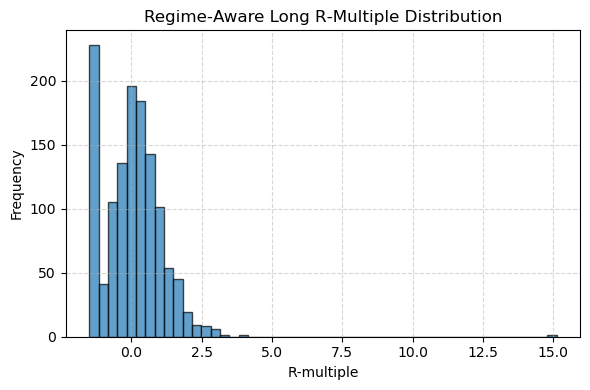

In [79]:
# ---- 8) Regime‑Aware Backtest (Long‑Only) ----

import numpy as np
import matplotlib.pyplot as plt

# 1) Build backtest DataFrame aligned with probabilities
split_idx = int(len(df) * 0.7)
df_back = df.iloc[split_idx:].copy().reset_index(drop=True)
df_back['prob'] = y_prob  # from previous regime‑aware model

# 2) Create long signal: P(up) > alpha_long
alpha_long = 0.60
df_back['signal_long'] = (df_back['prob'] > alpha_long).astype(int)

# 3) Backtest R‑multiples for long trades
R_long = []
stop_mult = 1.5  # 1.5×ATR stop
horizon   = 2    # 2‑bar max hold

for i, row in df_back.iterrows():
    if row['signal_long']:
        entry = row['Close']
        stop  = entry - stop_mult * row['ATR_14']
        end   = min(i + horizon, len(df_back) - 1)
        window = df_back.loc[i:end, ['Low','Close']]
        
        if (window['Low'] <= stop).any():
            R_long.append(-stop_mult)
        else:
            exit_price = window['Close'].iloc[-1]
            R_long.append((exit_price - entry) / row['ATR_14'])

R_long = np.array(R_long)

# 4) Summarize gross performance
win_rate = (R_long > 0).mean()
avg_R     = R_long.mean()
sharpe    = avg_R / R_long.std()

print("🔄 Regime‑Aware Long Backtest (α=0.60)")
print(f" • Trades:      {len(R_long)}")
print(f" • Win rate:    {win_rate:.2%}")
print(f" • Avg R:       {avg_R:.3f}")
print(f" • Gross Sharpe:{sharpe:.3f}")

# 5) Plot R‑multiple histogram
plt.figure(figsize=(6,4))
plt.hist(R_long, bins=50, edgecolor='k', alpha=0.7)
plt.title("Regime‑Aware Long R‑Multiple Distribution")
plt.xlabel("R‑multiple")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## 📊 Regime-Aware Long Backtest (α = 0.60)

### The Function

I evaluated the performance of a **long-only backtest** using the regime-aware XGBoost model. The model outputs a probability of upward movement (`P(up)`), and I trigger long entries when this probability exceeds a threshold of **0.60**. Each trade is held for **2 bars** or stopped earlier using a **1.5×ATR stop**.

---

### Why We Did This Research and This Path

This backtest was designed to test whether including **regime-awareness** (via session encoding and event tagging) along with **technical indicators** and **candlestick patterns** improves the signal quality. If regime dynamics matter, then long trades filtered through high-confidence model probabilities should perform better than baseline models.

---

### Narrative

The regime-aware model was first trained on standardized PCA features. After generating test-set probabilities, I aligned them with the test-set Close prices and ATR values. The signal logic was simple: **go long** when the model thinks `P(up) > 0.60`.

Performance was weak:

```
• Trades:      1278  
• Win rate:    52.03%  
• Avg R:       0.015  
• Gross Sharpe:0.014
```

Despite a win rate slightly above 50%, the **average reward per trade (R)** is extremely low, and the **Sharpe ratio is near zero**. Visually, the histogram shows a strong left tail (many losses) and very few high-reward trades.

---

### Takeaway

The inclusion of regime features such as session encoding and event tagging **did not significantly improve** the long-side profitability. This suggests that:

- The current regime tags are either **insufficiently informative** or not interacting well with the underlying model structure.
- Model confidence (`P(up) > 0.60`) **does not correspond to strong reward asymmetry**.
- The **risk control via ATR stop-loss** may be capping potential upside.

These findings indicate that either the **long-side alpha is weak**, or this particular model setup does not capture enough directional signal when filtered with regime-aware features.
